In [104]:
#Data Analysis
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
from string import punctuation
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from wordcloud import WordCloud, STOPWORDS

In [105]:
import missingno as msno 

In [106]:
# !pip install emot
# import emot

### Reading the data

In [110]:
train_df = pd.read_csv('../data/raw/train.csv')
test_df = pd.read_csv('../data/raw/test.csv')
print("Train shape : ", train_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (7613, 5)
Test shape :  (3263, 4)


### Overview of both train and test data sets 

In [111]:
pd.set_option('display.max_colwidth', 999)

1. **Train Data Set**

In [112]:
train_df.sample(5)

id     keyword                                    location  \
4565  6491    injuries  come here in 20 minutes for an ass kicking   
49      71      ablaze                                    England.   
2176  3119      debris                             Campo Grande-MS   
2356  3391  demolition                             Funtua, Nigeria   
24      36         NaN                                         NaN   

                                                                                                                                            text  \
4565           in fact if y'all could tag like small creeping or self inflicted injuries of the skin as derma (with brackets) that would be nice   
49    First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least.   
2176                                    [Reuters] Debris confirmed from MH370; relatives hope for discovery of crash site http://t.co/DFYaSVj7NF   
2356                                        Kaduna Begins Demolition Of Buildings On Govt School Lands\nhttp://t.co/77cIWXABVAÛ_t-school-lands/   
24                                                                                                                                      LOOOOOOL   

      target  
4565       0  
49         0  
2176       1  
2356       1  
24         0

In [113]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


### Number of missing values

In [114]:
def missing_values(df):
    missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    missing.columns=['missing values count', '%']
    return missing.sort_values(by='missing values count', ascending=False)
missing_values(train_df)

missing values count          %
location                  2533  33.272035
keyword                     61   0.801261
id                           0   0.000000
text                         0   0.000000
target                       0   0.000000

### Number of unique values

In [115]:
def return_unique_values(data_frame):
    unique_dataframe = pd.DataFrame()
    unique_dataframe['Features'] = data_frame.columns
    uniques = []
    for col in data_frame.columns:
        u = data_frame[col].nunique()
        uniques.append(u)
    unique_dataframe['Uniques'] = uniques
    return unique_dataframe

In [116]:
return_unique_values(train_df)

Features  Uniques
0        id     7613
1   keyword      221
2  location     3341
3      text     7503
4    target        2

2. **Test Data Set**

In [117]:
test_df.head()

id keyword location  \
0   0     NaN      NaN   
1   2     NaN      NaN   
2   3     NaN      NaN   
3   9     NaN      NaN   
4  11     NaN      NaN   

                                                                                               text  
0                                                                Just happened a terrible car crash  
1                                  Heard about #earthquake is different cities, stay safe everyone.  
2  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all  
3                                                          Apocalypse lighting. #Spokane #wildfires  
4                                                     Typhoon Soudelor kills 28 in China and Taiwan

In [118]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [119]:
missing_values(test_df)

missing values count          %
location                  1105  33.864542
keyword                     26   0.796813
id                           0   0.000000
text                         0   0.000000

In [120]:
import matplotlib as mpl
mpl.style.use('seaborn')

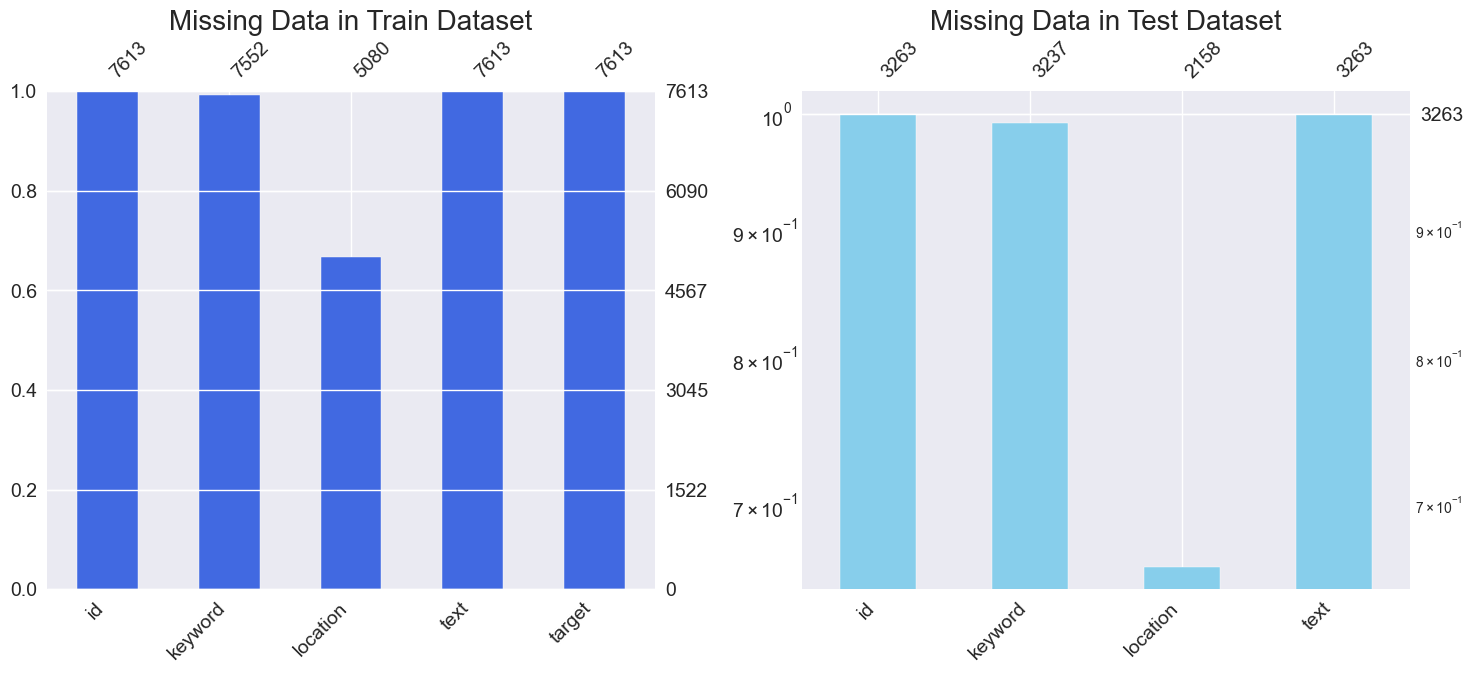

In [121]:
fig = plt.figure(figsize=(15,7))

ax1 = fig.add_subplot(1,2,1)
msno.bar(train_df, color="royalblue", fontsize=14, ax=ax1, labels=True, );
ax1.set_title('Missing Data in Train Dataset', fontsize= 20)

ax2 = fig.add_subplot(1,2,2)
msno.bar(test_df, log=True, color="skyblue", fontsize=14, ax=ax2, labels=True);
ax2.set_title('Missing Data in Test Dataset', fontsize= 20)


plt.tight_layout()
plt.show()

In [122]:
return_unique_values(test_df)

Features  Uniques
0        id     3263
1   keyword      221
2  location     1602
3      text     3243

## Target Distribution in the training dataset

In [124]:
def distribution_bar_plot(feature, df, dataset):

    fig, ax = plt.subplots(figsize=(8, 2))    
    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[feature].value_counts().index, ax=ax, palette='Blues')
    ax.set_title(f'The Percentage Count of "{feature}" on {dataset} set', )
    ax.set_xlabel('Percentage Count')
    ax.set_ylabel(f'{feature}')
    #ax.axis("off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
        
    plt.show()

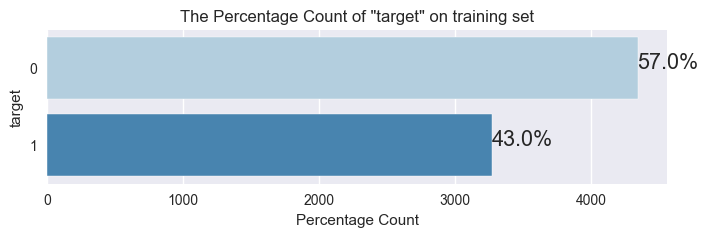

In [125]:
distribution_bar_plot('target', train_df, 'training')

## Check for Duplicates in Training Data Set

1. **The entire training set**

In [126]:
print(f'There are {train_df.duplicated().sum()} duplicates considering all columns in the data set' )

There are 0 duplicates considering all columns in the data set


2. **Check  duplicates in the "text" column**

In [127]:
print(f'There are {train_df["text"].duplicated().sum()} duplicated text in the "text" column' )

There are 110 duplicated text in the "text" column


### We need to make sure that duplicated text values are labeled the same 

3. **Check if duplicates in the "text" column has a consistent target value**

In [128]:
print(f"Out of 110, there are only {train_df[['text', 'target']].duplicated().sum()} of duplicated text labeled the same")

Out of 110, there are only 92 of duplicated text labeled the same


In [129]:
print(f'there are {110 -92} inconsistent labels of the duplicates')

there are 18 inconsistent labels of the duplicates


- Filter text with inconsistent target values

In [130]:
inconsistent_lebeled_subset = train_df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
inconsistent_lebeled_subset = inconsistent_lebeled_subset[inconsistent_lebeled_subset['target'] > 1][['target']]
inconsistent_lebeled_subset

target
text                                                                                                                                               
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit                     2
Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!                                2
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                                2
In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!                                            2
To fight bioterrorism sir.                                                                                                                        2
Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE       2
#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption                             2
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect        2
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                       2
RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG                                                    2
Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife                                              2
CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring                                                          2
Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...                                                              2
wowo--=== 12000 Nigerian refugees repatriated from Cameroon                                                                                       2
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4            2
Caution: breathing may be hazardous to your health.                                                                                               2
I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????                                                                2
that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time                 2

- Review all text with inconsistent target values to be  fixed

In [131]:
inconsistent_lebeled_text= list(inconsistent_lebeled_subset.index)

In [132]:
inconsistent_lebeled_subset = train_df[train_df['text'].isin(inconsistent_lebeled_text)].sort_values(by='text', ascending=False)
inconsistent_lebeled_subset

id              keyword                    location  \
5641  8044             refugees                         NaN   
5620  8018             refugees                         NaN   
6091  8698              sinking    Every Where in the World   
6123  8739              sinking                          MA   
6103  8714              sinking                         NaN   
6094  8702              sinking                         NaN   
1221  1760  buildings%20burning                      dallas   
1349  1950  burning%20buildings                      dallas   
4019  5710               floods                         NaN   
4013  5699               floods                         NaN   
3985  5662               floods                         NaN   
624    898         bioterrorism                         NaN   
610    881         bioterrorism                         NaN   
634    916         bioterrorism                         NaN   
630    907         bioterrorism                         NaN   
4318  6132             hellfire                         NaN   
4309  6118             hellfire                         NaN   
4304  6111             hellfire                         NaN   
4292  6097             hellfire                         NaN   
4286  6090             hellfire                      Riyadh   
4284  6087             hellfire                         NaN   
4381  6223             hijacker                   worldwide   
4379  6220             hijacker                   worldwide   
1331  1922  burning%20buildings      Mackay, QLD, Australia   
1197  1723  buildings%20burning      Mackay, QLD, Australia   
6614  9470            terrorism        Jeddah_Saudi Arabia.   
6616  9472            terrorism                      Riyadh   
1214  1752  buildings%20burning              Epic City, BB.   
1365  1968  burning%20buildings              Epic City, BB.   
4320  6134             hellfire                   Riyadh ')   
4306  6113             hellfire                         NaN   
4285  6088             hellfire                         NaN   
4305  6112             hellfire                         NaN   
4313  6125             hellfire                         NaN   
3240  4656             engulfed                         NaN   
3266  4691             engulfed                         NaN   
3261  4684             engulfed                         NaN   
3251  4672             engulfed                         NaN   
3248  4669             engulfed                     Bahrain   
3243  4659             engulfed                     Kuwait    
4232  6012            hazardous                         NaN   
4235  6017            hazardous                         NaN   
4605  6548               injury                         NaN   
4618  6566               injury                         NaN   
4597  6537               injury                         NaN   
2831  4072            displaced    Pedophile hunting ground   
2832  4076            displaced    Pedophile hunting ground   
2830  4068            displaced    Pedophile hunting ground   
2833  4077            displaced    Pedophile hunting ground   
4239  6023            hazardous           Mysore, Karnataka   
4221  5996            hazardous                         NaN   
4244  6031            hazardous            New Delhi, Delhi   
4312  6123             hellfire          ?????? ???? ??????   
4299  6105             hellfire  ?????? ??? ?????? ????????   
4290  6094             hellfire    Jubail IC, Saudi Arabia.   

                                                                                                                                             text  \
5641                                                                                  wowo--=== 12000 Nigerian refugees repatriated from Cameroon   
5620                                                                                  wowo--=== 12000 Nigerian refugees repatriated from Cameroon   
6091            that horrible si

## Fixing inconsistent labels manually (hard coding) using the author judgment 

In [133]:
train_df['Disaster'] = train_df.loc[:, ['target']]

In [134]:
inconsistent_lebeled_subset.index

Int64Index([5641, 5620, 6091, 6123, 6103, 6094, 1221, 1349, 4019, 4013, 3985,
             624,  610,  634,  630, 4318, 4309, 4304, 4292, 4286, 4284, 4381,
            4379, 1331, 1197, 6614, 6616, 1214, 1365, 4320, 4306, 4285, 4305,
            4313, 3240, 3266, 3261, 3251, 3248, 3243, 4232, 4235, 4605, 4618,
            4597, 2831, 2832, 2830, 2833, 4239, 4221, 4244, 4312, 4299, 4290],
           dtype='int64')

In [135]:
train_df.iloc[[5641, 5620], 5] = 0
train_df.iloc[[6091, 6123, 6103, 6094,], 5] = 0
train_df.iloc[[1221, 1349], 5] = 0
train_df.iloc[[4019, 4013, 3985], 5] = 0
train_df.iloc[[624,  610,  634,  630], 5] = 0
train_df.iloc[[4318, 4309, 4304, 4292, 4286, 4284], 5] = 0
train_df.iloc[[4381, 4379], 5] = 1
train_df.iloc[[1331, 1197], 5] = 1
train_df.iloc[[6614, 6616], 5] = 0
train_df.iloc[[1214, 1365], 5] = 1
train_df.iloc[[4320, 4306], 5] = 0
train_df.iloc[[4285, 4305, 4313], 5] = 0
train_df.iloc[[3240, 3266, 3261, 3251, 3248, 3243], 5] = 0
train_df.iloc[[4232, 4235], 5] = 0
train_df.iloc[[4605, 4618, 4597], 5] = 1
train_df.iloc[[2831, 2832, 2830, 2833], 5] = 1
train_df.iloc[[4239, 4221, 4244], 5] = 1
train_df.iloc[[4312, 4299, 4290], 5] = 1

- Checking target consistency of duplicated text

In [136]:
train_df[['text']].duplicated().sum()

110

In [137]:
train_df[['text', 'Disaster']].duplicated().sum()

110

**All duplicated text have a consistent target values.**

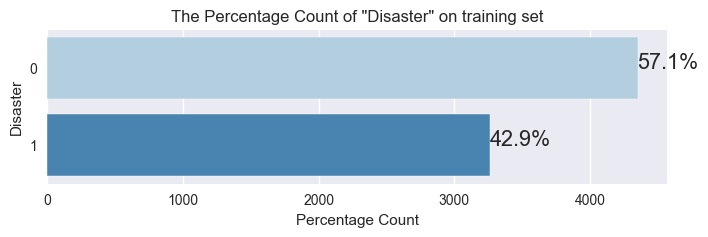

In [138]:
distribution_bar_plot('Disaster', train_df, 'training')

The distribution of the target values changes by 0.1% after fixing the inconsistency in the target values for the duplicates.

## Inspecting the "location" feature

In [139]:
# Calculating missing values
missing_values(train_df[['location']])

missing values count          %
location                  2533  33.272035

### a view of some unique locations in the data set

In [140]:
train_df[['location']].nunique()

location    3341
dtype: int64

In [141]:
print(np.random.choice(train_df['location'].unique(),20))

['texas a&m university' 'brisbane, australia' 'Giddy, Greenland'
 'beacon hills ' 'fluffy cloud' 'Cape Town, Khayelitsha' 'Kensington, MD'
 'Hearts & Minds' 'Rock Hill, SC' 'Kettering, OH'
 'St. Catharines, Ontario' 'PDX' 'Nicola Valley' 'I ACCEPT SONG REQUESTS'
 'CHICAGO' 'Greensburg, PA' 'New Britain, CT' 'have car; will travel'
 'Kawartha Lakes, Ontario, Canad' 'lugo']


In [142]:
def frequency_counts(feature, df=train_df):
    ''' Calculates the count and percentage of each value of column'''
    counts = pd.concat([df[feature].value_counts(), round(100 * df[feature].value_counts()/df.shape[0], 2)], axis=1)
    counts.columns=['count', '% of dataset']
    counts.reset_index(inplace =True)
    counts.rename(columns={'index': feature}, inplace=True)
    return counts

In [143]:
frequency_counts(['location'], df=train_df)

location  count  % of dataset
0                USA    104          1.37
1           New York     71          0.93
2      United States     50          0.66
3             London     45          0.59
4             Canada     29          0.38
...              ...    ...           ...
3336     Hueco Mundo      1          0.01
3337      Hughes, AR      1          0.01
3338  Huntington, WV      1          0.01
3339     Huntley, IL      1          0.01
3340     åø\_(?)_/åø      1          0.01

[3341 rows x 3 columns]

## Insights:
- 33% of the location feature is missing.
- The are 3341 unique location for the tweets.
- The location in this data set is not consistent. We see some tweets' location as a country and others as a city. 

- the USA is the most frequent location for the tweets, followed by New York, then united states representing (1.37%, 0.93%, and 0.66%) of the tweets respectively.
- **However, With this large number of missing values, it is not feasible to clean the location values. The location in this data set is not good to be predictive feature and will not be considered in the modeling.**

## Inspecting the "keyword" feature

1. **Missing values**

In [144]:
# Calculating missing values
print('Missing values of keyword in train dataset:')
missing_values(train_df[['keyword']])

Missing values of keyword in train dataset:


missing values count         %
keyword                    61  0.801261

In [145]:
# Calculating missing values
print('Missing values of keyword in test dataset:')
missing_values(test_df[['keyword']])

Missing values of keyword in test dataset:


missing values count         %
keyword                    26  0.796813

2. **Unique Values**

In [146]:
print("The number of unique keywords in train set tweets is:", train_df['keyword'].nunique())
print("The number of unique keywords in test set tweets is:", test_df['keyword'].nunique())

The number of unique keywords in train set tweets is: 221
The number of unique keywords in test set tweets is: 221


### Keyword frequency count along with their percentage appearance of the dataset

* **Note: The frequency count and percentage are calculated based on a particular class (Disaster or No Disaster) size not all the data set.**

In [147]:
print('most fequent 15 keywords in train dataset:')
frequency_counts(['keyword'], df=train_df).set_index('keyword')[:15]

most fequent 15 keywords in train dataset:


count  % of dataset
keyword                         
fatalities      45          0.59
deluge          42          0.55
armageddon      42          0.55
sinking         41          0.54
damage          41          0.54
harm            41          0.54
body%20bags     41          0.54
outbreak        40          0.53
evacuate        40          0.53
fear            40          0.53
collided        40          0.53
siren           40          0.53
twister         40          0.53
windstorm       40          0.53
sinkhole        39          0.51

In [148]:
print('most fequent 15 keywords in test dataset:')
frequency_counts(['keyword'], df=test_df).set_index('keyword')[:15]

most fequent 15 keywords in test dataset:


count  % of dataset
keyword                                
deluged                23          0.70
demolished             22          0.67
rubble                 22          0.67
first%20responders     21          0.64
seismic                21          0.64
obliteration           21          0.64
sirens                 21          0.64
annihilation           21          0.64
snowstorm              21          0.64
avalanche              20          0.61
dead                   20          0.61
mayhem                 20          0.61
bioterrorism           20          0.61
catastrophic           20          0.61
survivors              20          0.61

### Keyword Count, Percentage and Probability of indicating a Disaster Tweet

In [149]:
def kw_distribution(df, feature): 
    """this function returns word cuonts, keywords percentage in dataset rows,
    and the keyword probability off indicating disater tweet"""
    counts = pd.concat([df[feature].value_counts(), round(100 * df[feature].value_counts()/df.shape[0], 2)], axis=1)
    counts.columns=['count', '% of dataset rows']
    prop = df.groupby(feature).agg({'Disaster':np.mean}).rename(columns={'Disaster':'Probability of Disaster'})
    joined = counts.join(prop).sort_values('Probability of Disaster', ascending=False)
    joined.index.rename('keyword', inplace=True)
    return joined

In [150]:
print('Top 15 keywords with highest probability of indicating disaster tweet')
kw_distribution(train_df, 'keyword')[:15]

Top 15 keywords with highest probability of indicating disaster tweet


count  % of dataset rows  Probability of Disaster
keyword                                                              
derailment             39               0.51                 1.000000
wreckage               39               0.51                 1.000000
debris                 37               0.49                 1.000000
outbreak               40               0.53                 0.975000
typhoon                38               0.50                 0.973684
oil%20spill            38               0.50                 0.973684
suicide%20bombing      33               0.43                 0.969697
suicide%20bomber       31               0.41                 0.967742
bombing                29               0.38                 0.931034
suicide%20bomb         35               0.46                 0.914286
rescuers               35               0.46                 0.914286
nuclear%20disaster     34               0.45                 0.911765
evacuated              36               0.47                 0.888889
razed                  35               0.46                 0.885714
wildfire               33               0.43                 0.878788

In [151]:
print('Top 15 keywords with lowest probability of indicating None Disaster tweet')
kw_distribution(train_df, 'keyword').sort_values('Probability of Disaster')[:15]

Top 15 keywords with lowest probability of indicating None Disaster tweet


count  % of dataset rows  Probability of Disaster
keyword                                                       
aftershock      34               0.45                 0.000000
body%20bags     41               0.54                 0.024390
ruin            37               0.49                 0.027027
blazing         34               0.45                 0.029412
body%20bag      33               0.43                 0.030303
electrocute     32               0.42                 0.031250
screaming       36               0.47                 0.055556
traumatised     35               0.46                 0.057143
panicking       33               0.43                 0.060606
blew%20up       33               0.43                 0.060606
blight          32               0.42                 0.062500
wrecked         39               0.51                 0.076923
explode         38               0.50                 0.078947
panic           37               0.49                 0.081081
epicentre       12               0.16                 0.083333

### Plotting keywords distribution of frequency count and percentage across classes (disaster = 1 colored  blue, none disaster = 0 colored orange)

* **Note: The frequency count and percentage are calculated based on the entire data set.**

In [152]:
def distribution_bar_plot(feature, df, dataset):

    fig, ax = plt.subplots(figsize=(15, 85), dpi=100)    
    # Ploting just the distribution of each variable values in the first subplot
    sns.countplot(y=feature, data=df, order = df[df['Disaster'] == 1][feature].value_counts().index, ax=ax, hue='Disaster', palette='RdBu')
    ax.set_title(f'The Percentage Count of "{feature}" in {dataset} set', )
    ax.set_xlabel('Percentage Count')
    ax.set_ylabel(f'{feature}')
    #ax.axis("off")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel(f'{feature}')
    total = len(df[feature])
    for p in ax.patches:
            percentage = '{:.2f}%'.format(100 * p.get_width()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
    ax.tick_params(axis='y', labelsize=14)
    plt.show()

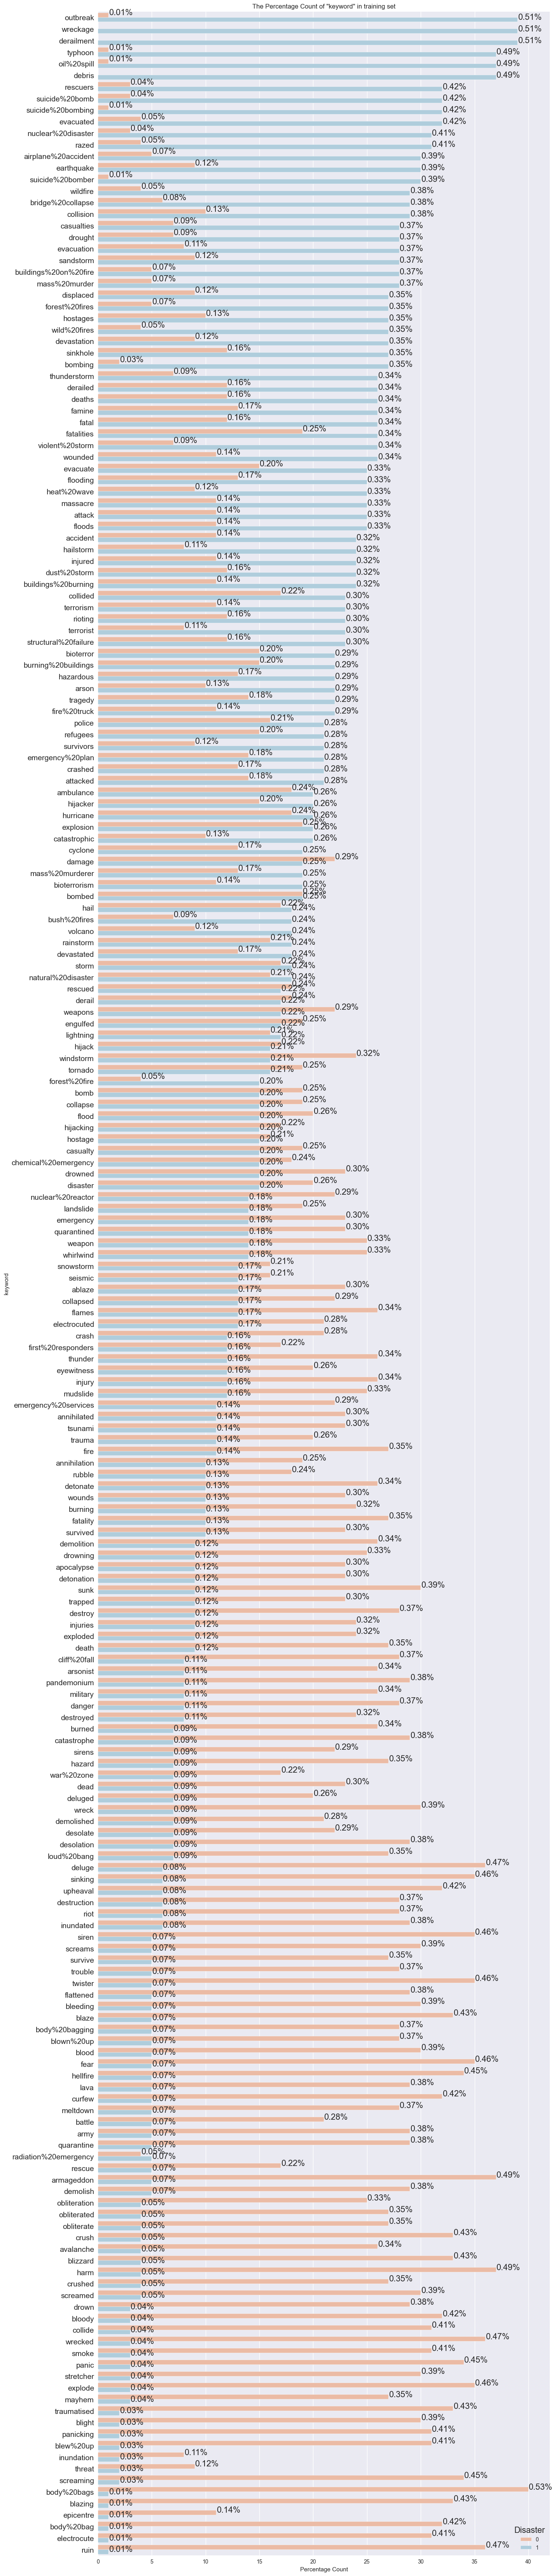

In [153]:
distribution_bar_plot('keyword', train_df, 'training')

## Insights:
- There are 61 (0.8%) missing keywords in this dataset.
- the keywords derailment, wreckage, and debris are only appeared in the disaster tweets with disaster probability = 1. Also, outbreak, typhoon, oil%20omb, suicide%20bombing and rescuers has more than 90% probability of indicating disaster tweet.
- keywords like aftershock, body%20bags, ruin, blazing, body%20bag, electrocute, screaming, traumatised, and blew%20up are mostly appeared in the none disaster tweets where indicating near zero probability of disaster tweets.
- there are many other keywords that are existed in both classes. The keyword without the context can not be a good predictive of the disaster tweets.

## Inspecting the "text" feature

### Plotting Words Cloud
plotting word cloud before cleaning the data, only removing stopping words.

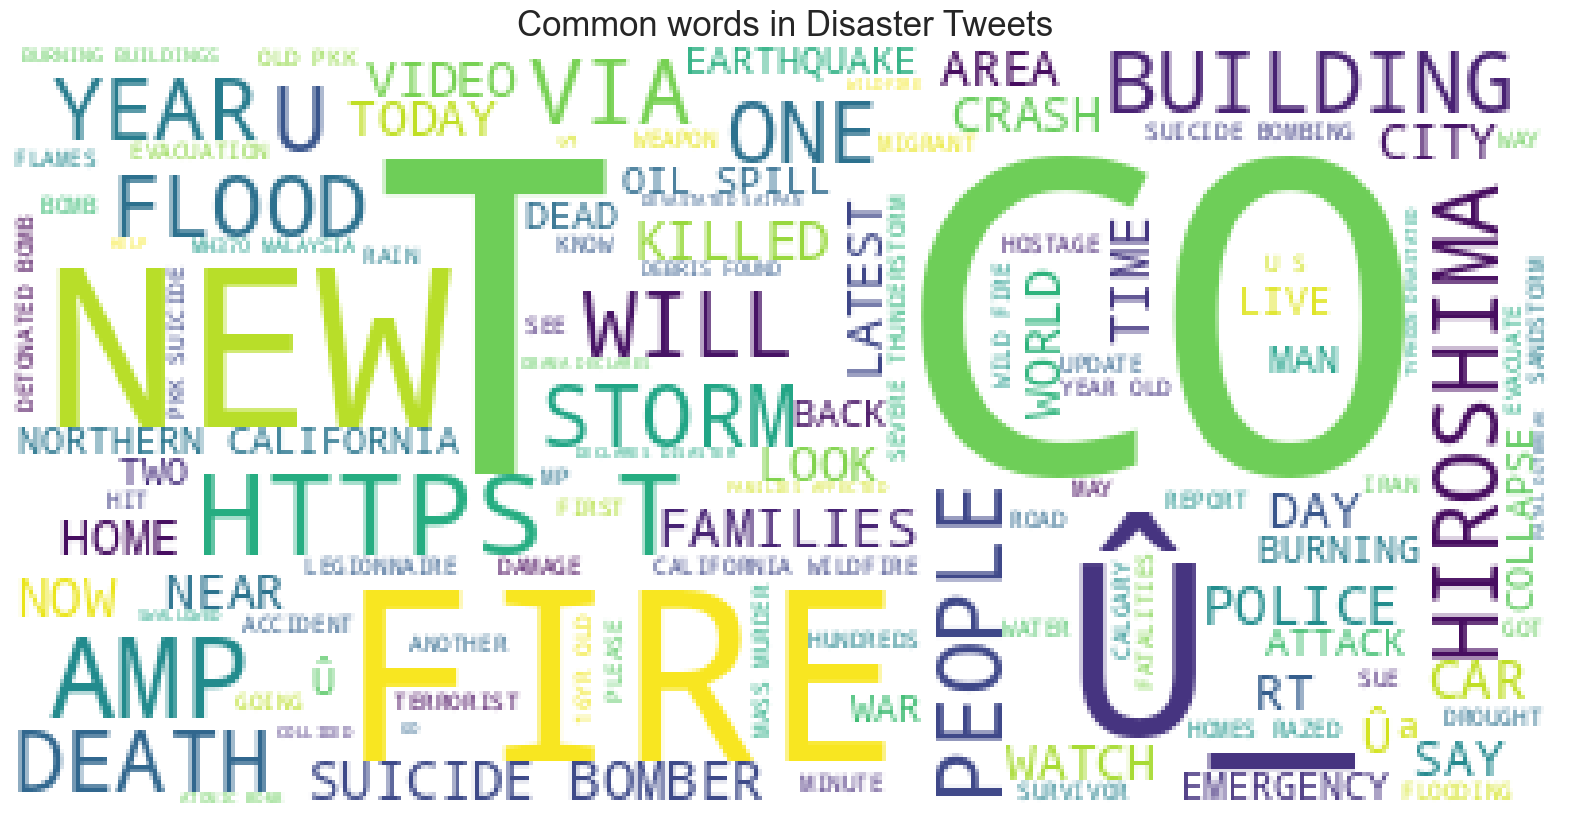

In [155]:
def cloud(text, target):
    plt.subplots(figsize=(20, 30))
    wordcloud = WordCloud(background_color="white",stopwords=STOPWORDS).generate(" ".join([i for i in text.str.upper()]))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Common words in {target} Tweets", fontsize=25)
    plt.show()
cloud(train_df[train_df.Disaster == 1]['text'], 'Disaster' )


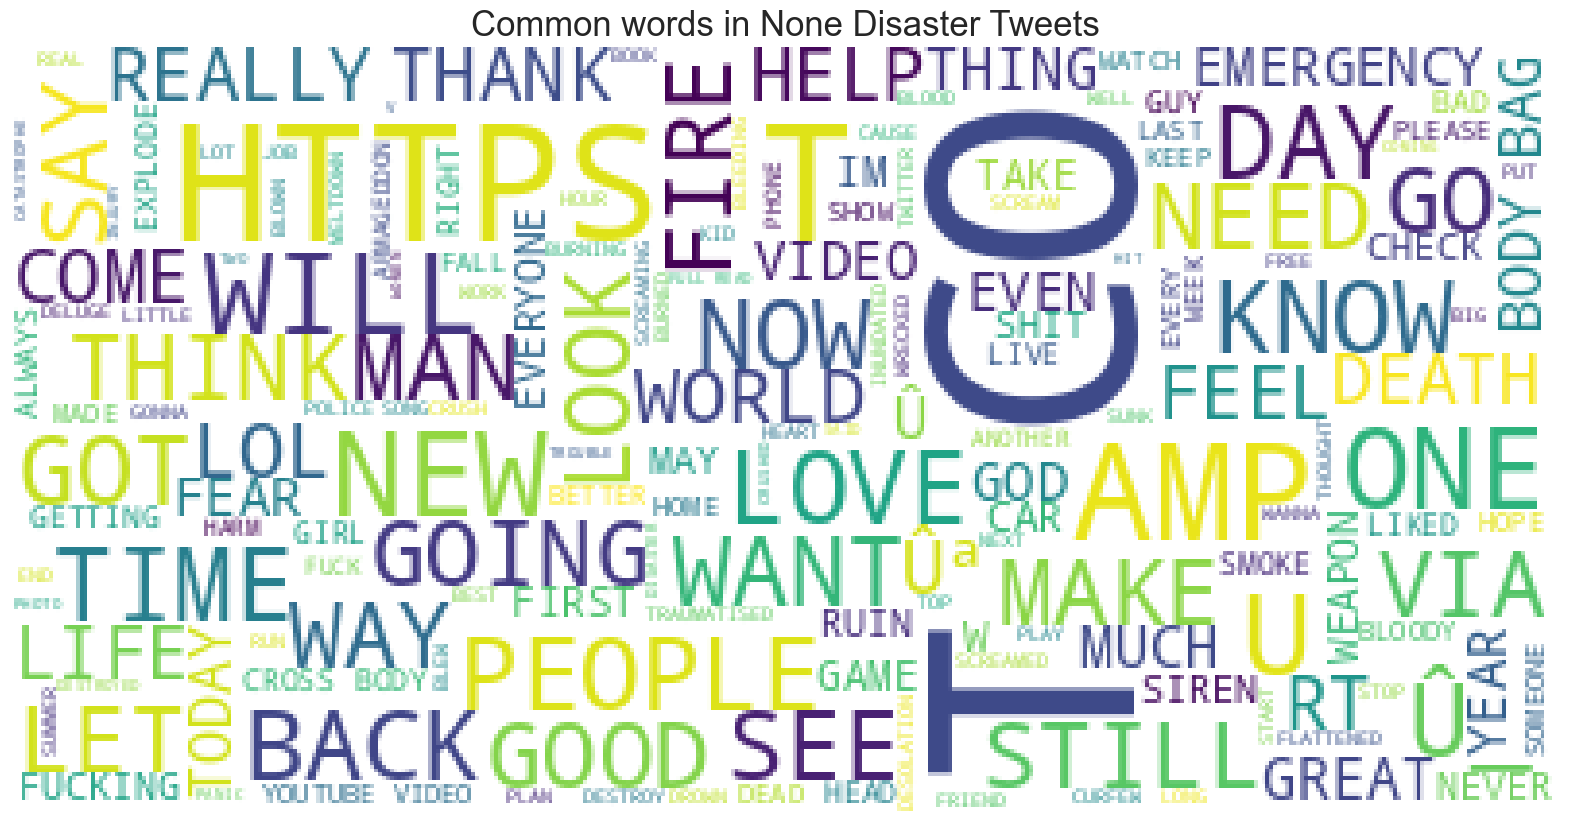

In [156]:
cloud(train_df[train_df.Disaster == 0]['text'], 'None Disaster' )

## **Meta Data Analysis**

### Tweets length (number of characters) distribution for Disaster and None Disaster classes

In [157]:
# add text_lenght column to the train dataset
train_df['text_lenght'] = train_df.loc[:, 'text'].apply(len)

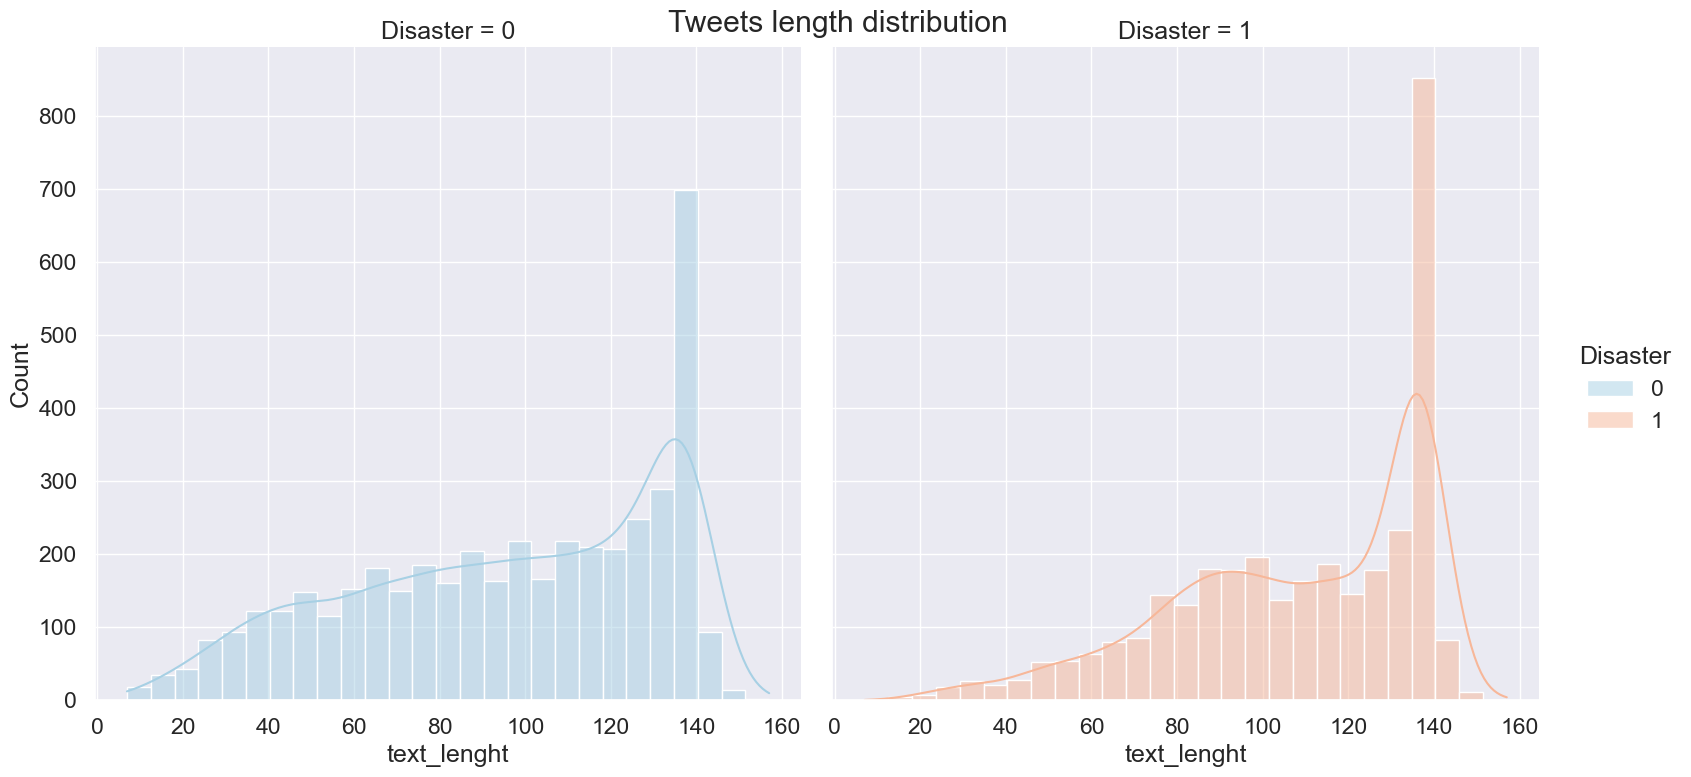

In [158]:
sns.set(font_scale = 1.5)

plot = sns.displot(train_df, x="text_lenght", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle("Tweets length distribution")
plt.show()

### Word count distribution for tweets

In [159]:
# add text_lenght column to the train dataset
train_df['wordcount'] = train_df.loc[:, 'text'].apply(lambda x: len(str(x).split()))

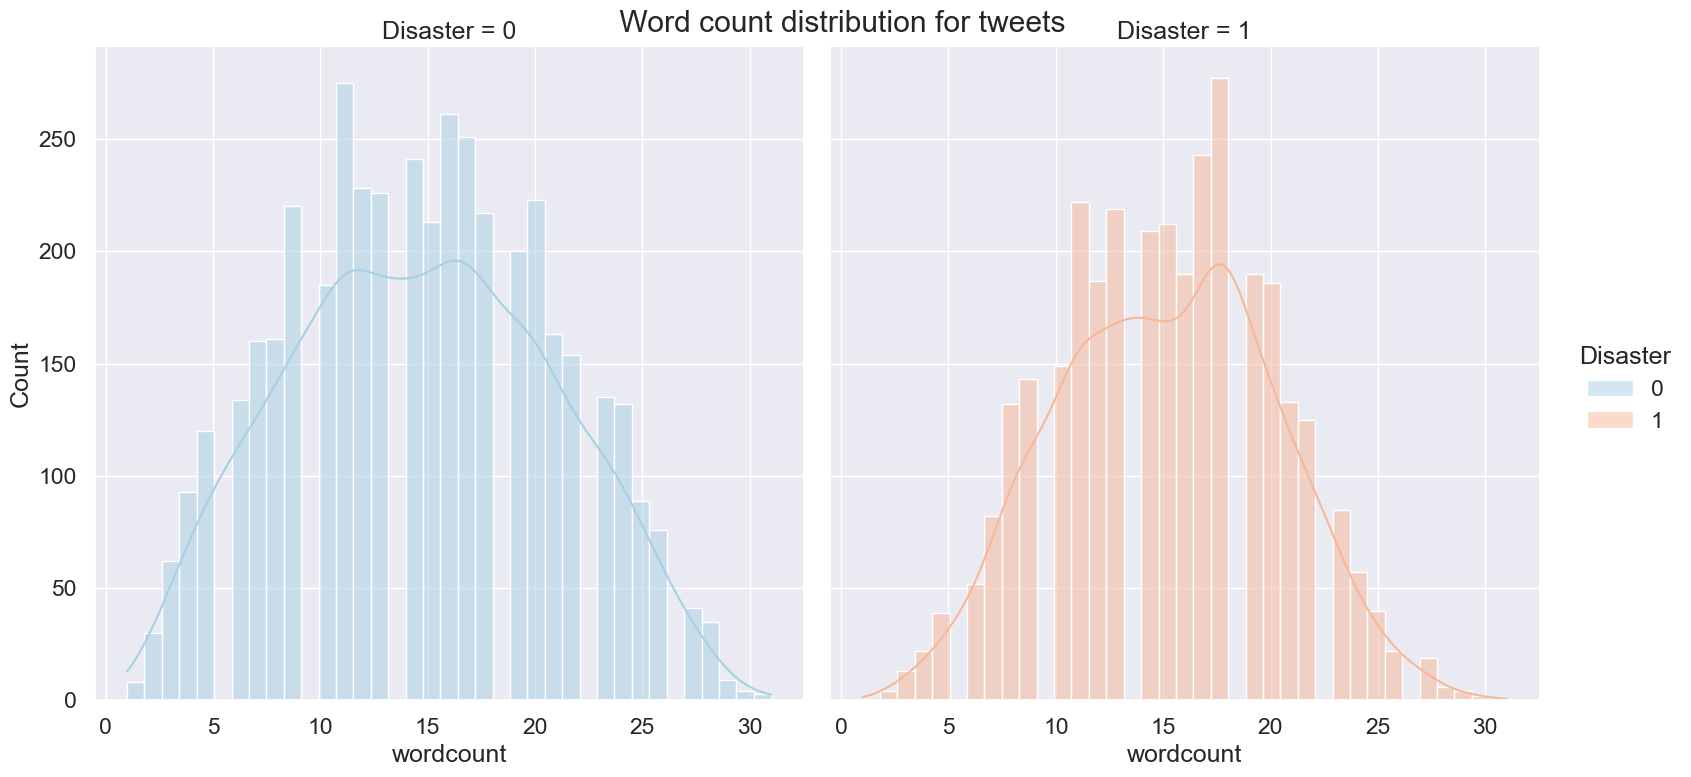

In [160]:
plot = sns.displot(train_df, x="wordcount", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle(" Word count distribution for tweets")
plt.show()

### Average and Maximum word length in a tweet

In [161]:
train_df['max_word_lenght']= train_df['text'].str.split().apply((lambda x : max([len(i) for i in x])))
train_df['avg_word_lenght']= train_df['text'].str.split().apply((lambda x : np.mean([len(i) for i in x])))

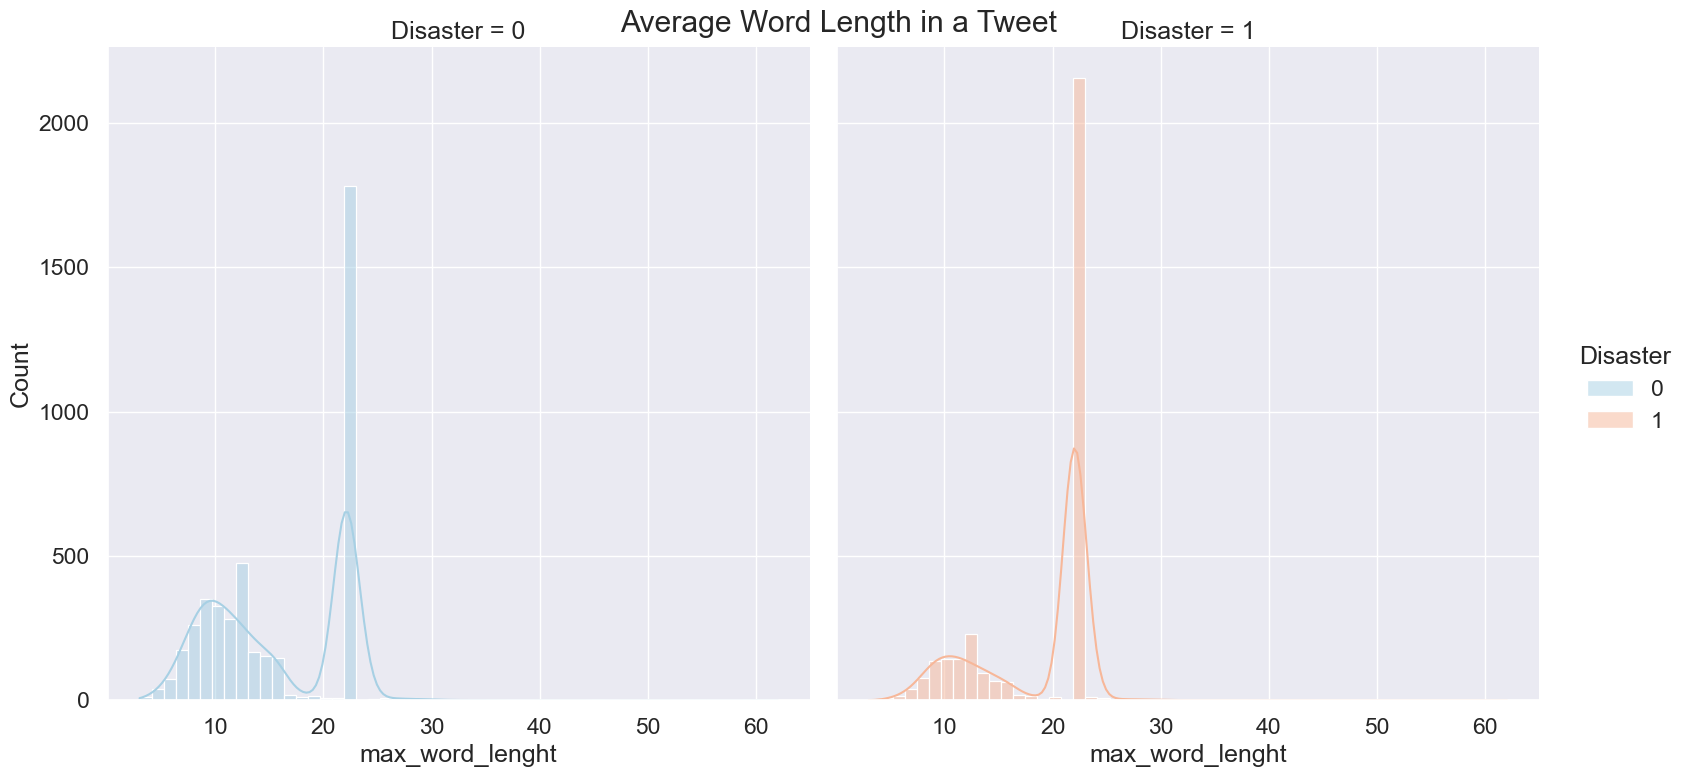

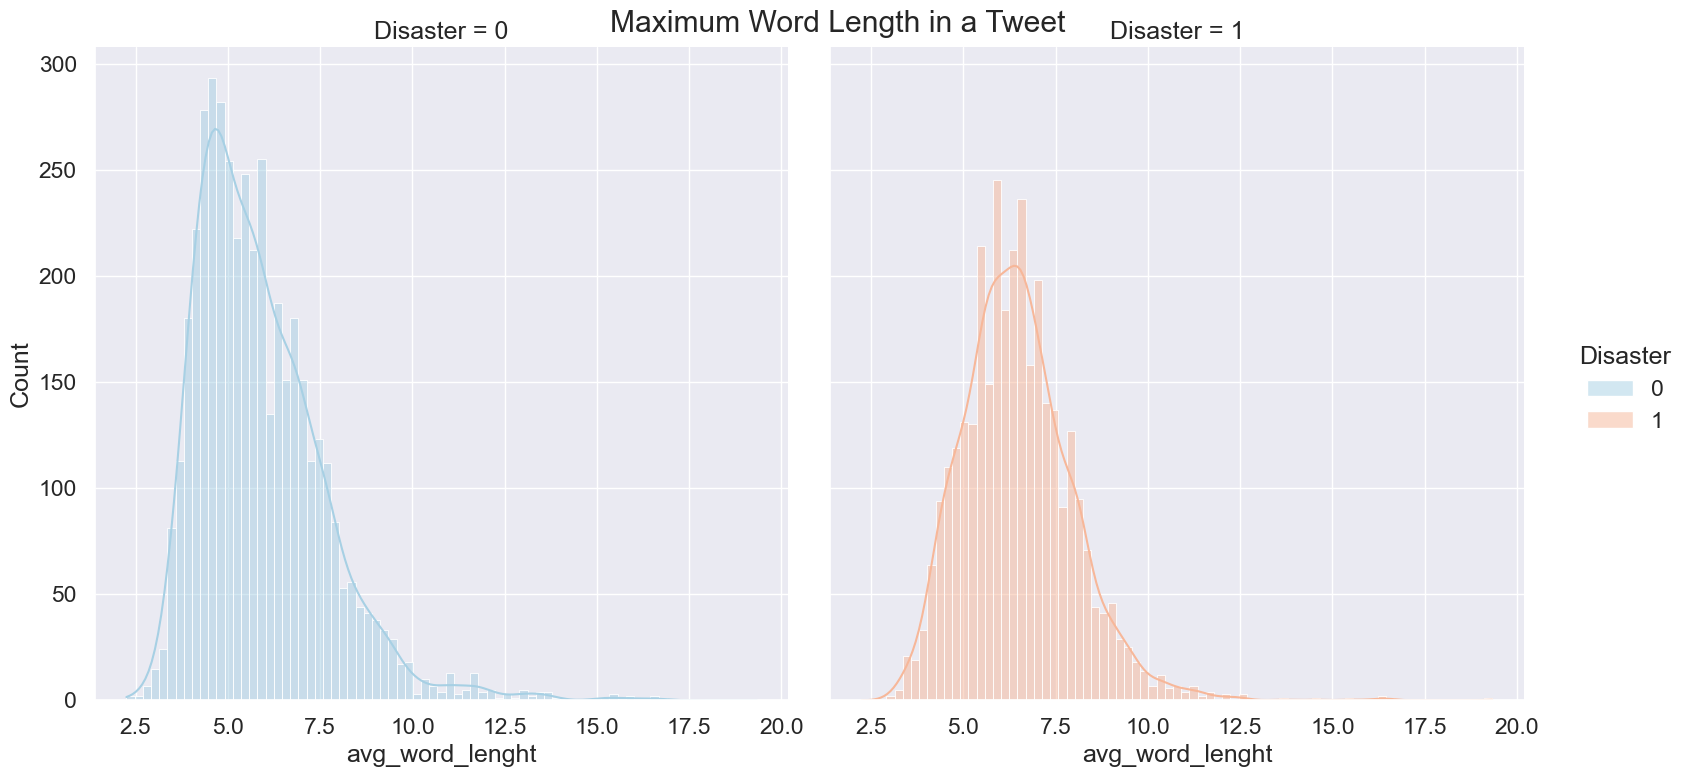

In [162]:
plot = sns.displot(train_df, x="max_word_lenght", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle("Average Word Length in a Tweet")
plot = sns.displot(train_df, x="avg_word_lenght", col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
plot.fig.suptitle("Maximum Word Length in a Tweet")
plt.show()

## Insights:
- The Meta data features of both classes have a similar distribution.
- None of these Meta data features seems to be a good predictor of the disaster tweets.
- We will further check the predictive power of these features later in this analysis.

## **Exploring Common Words and Phrases**

### Common Words using N_Gram

In [163]:
# thanks to: https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a
def get_top_n_words(corpus, ngram=1, stop_words=None, n=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    common_words = words_freq[:n]
    df = pd.DataFrame(common_words, columns = ['phrase' , 'count'])
    df = df.groupby('phrase').sum()['count'].sort_values(ascending=False)
    return df


### 1.1 The distribution of top unigrams before removing stop words

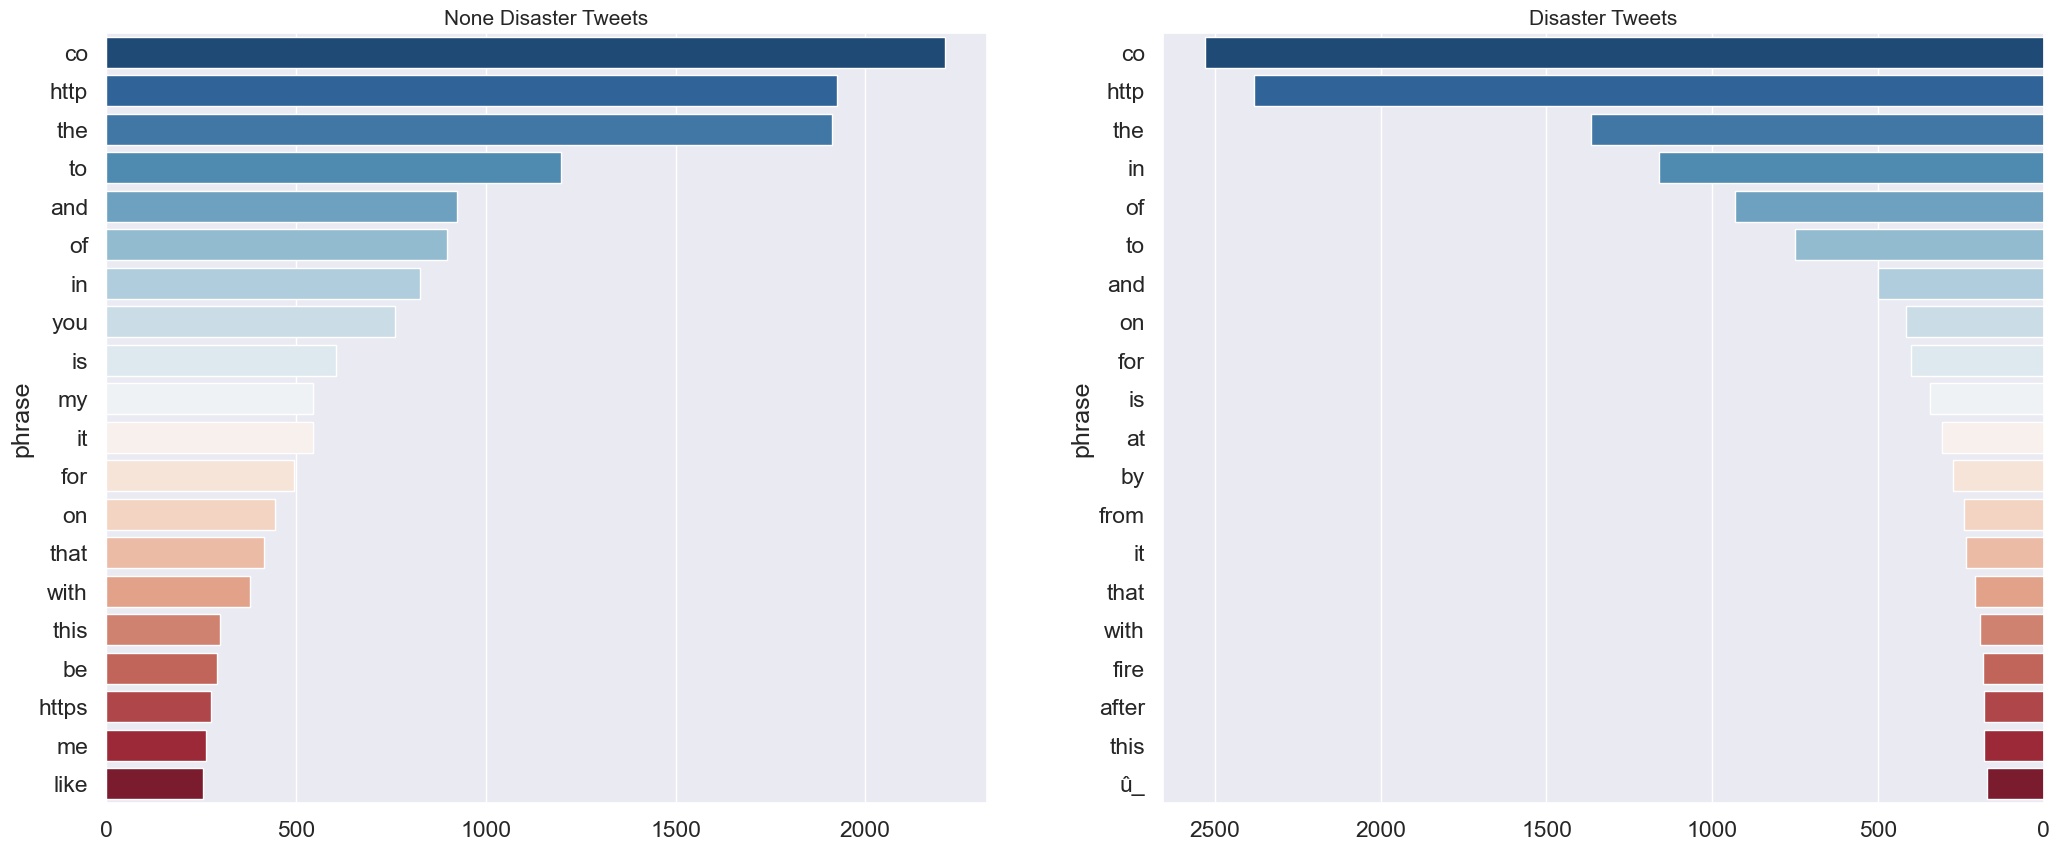

In [164]:
df_pos = get_top_n_words(train_df[train_df['Disaster'] == 1]['text'], n=20)
df_neg = get_top_n_words(train_df[train_df['Disaster'] == 0]['text'], n=20)

def plot_ngram(df_pos, df_neg):
    """This function plots ngram distribution for both classes"""

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(25, 10))
    sns.barplot(y = df_pos.index, x = df_pos.values, palette='RdBu_r', ax=ax[1])
    plt.gca().invert_xaxis()
    ax[1].set_title('Disaster Tweets', fontsize= 15)

    sns.barplot(y = df_neg.index, x = df_neg.values, palette='RdBu_r', ax=ax[0])
    ax[0].set_title('None Disaster Tweets', fontsize= 15)
    plt.show()
plot_ngram(df_pos, df_neg)

## Removing URLs from tweets

In [165]:
def remove_url(text):
    return re.sub(r"http\S+", "", text)

In [166]:
# cleaning urls from tweets in train dataset
train_df.loc[:, 'text'] = train_df['text'].apply(remove_url)

In [167]:
# cleaning urls from tweets in test dataset
test_df.loc[:, 'text'] = test_df['text'].apply(remove_url)

### 1.2 The distribution of top unigrams after removing stop words

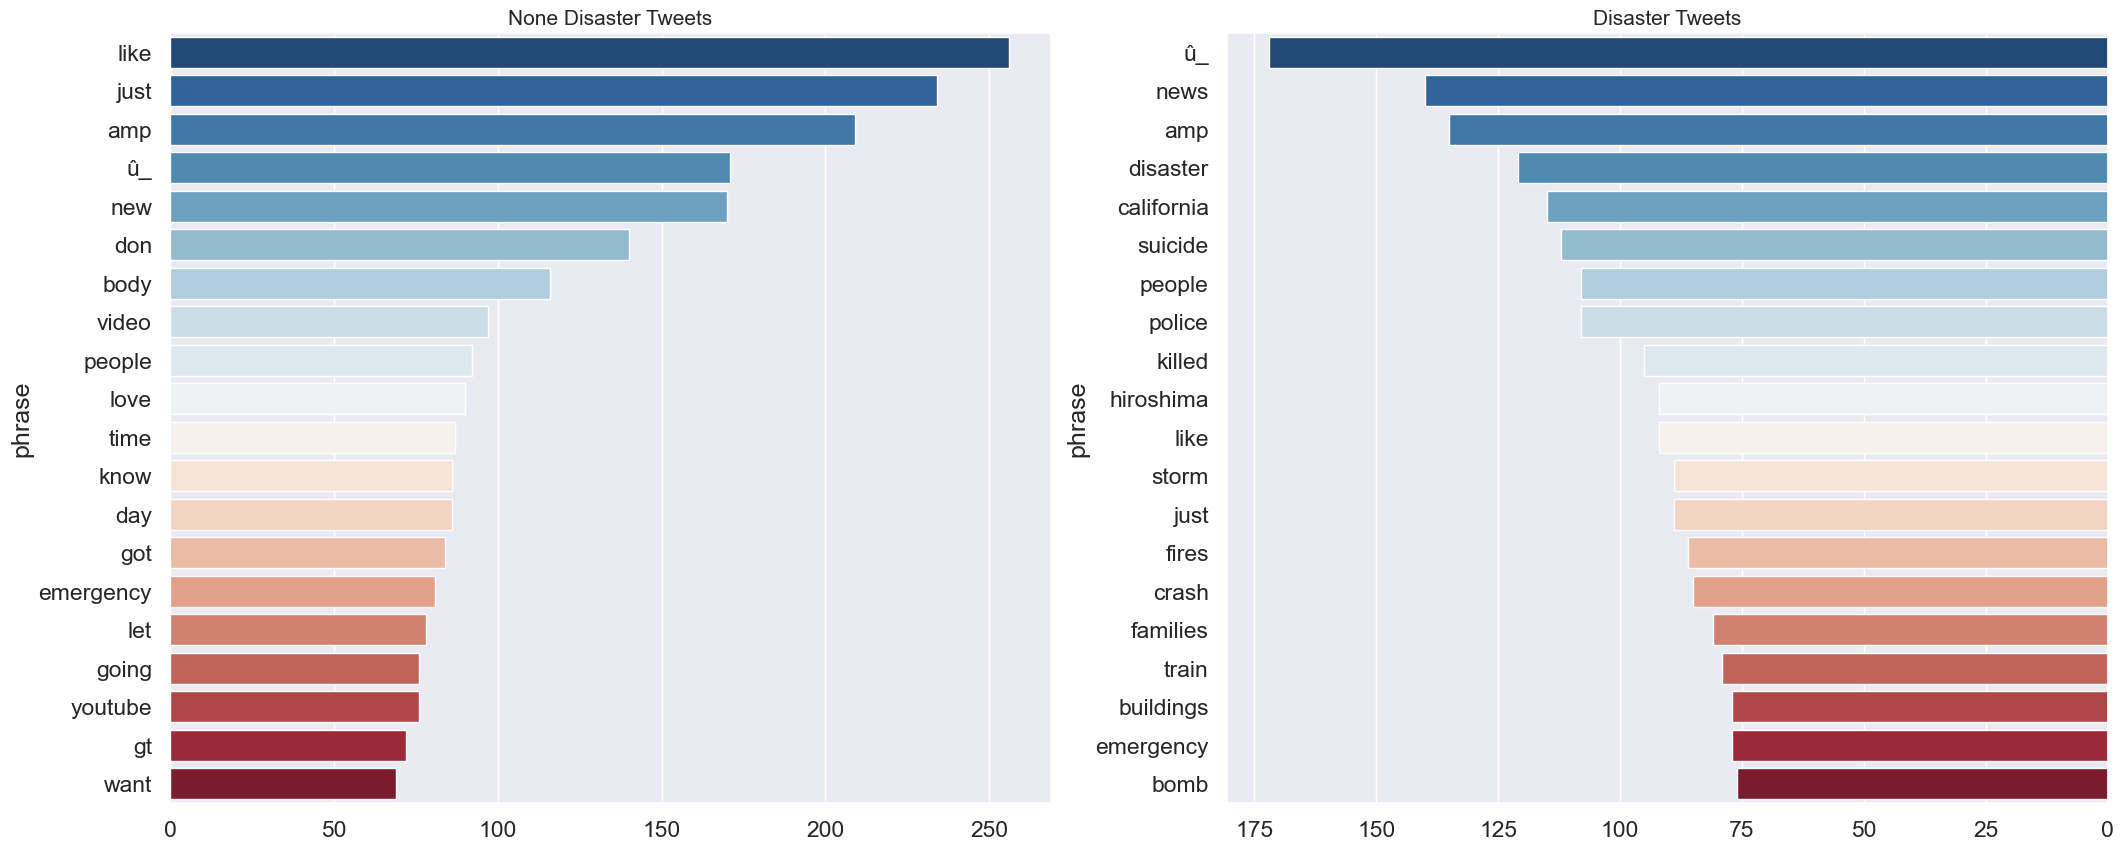

In [169]:
df_pos = get_top_n_words(corpus= train_df[train_df['Disaster'] == 1]['text'], ngram=1, stop_words= 'english', n=20)
df_neg = get_top_n_words(corpus= train_df[train_df['Disaster'] == 0]['text'], ngram=1, stop_words= 'english', n=20)
plot_ngram(df_pos, df_neg)

### 2.1 The distribution of top bigrams before removing stop words

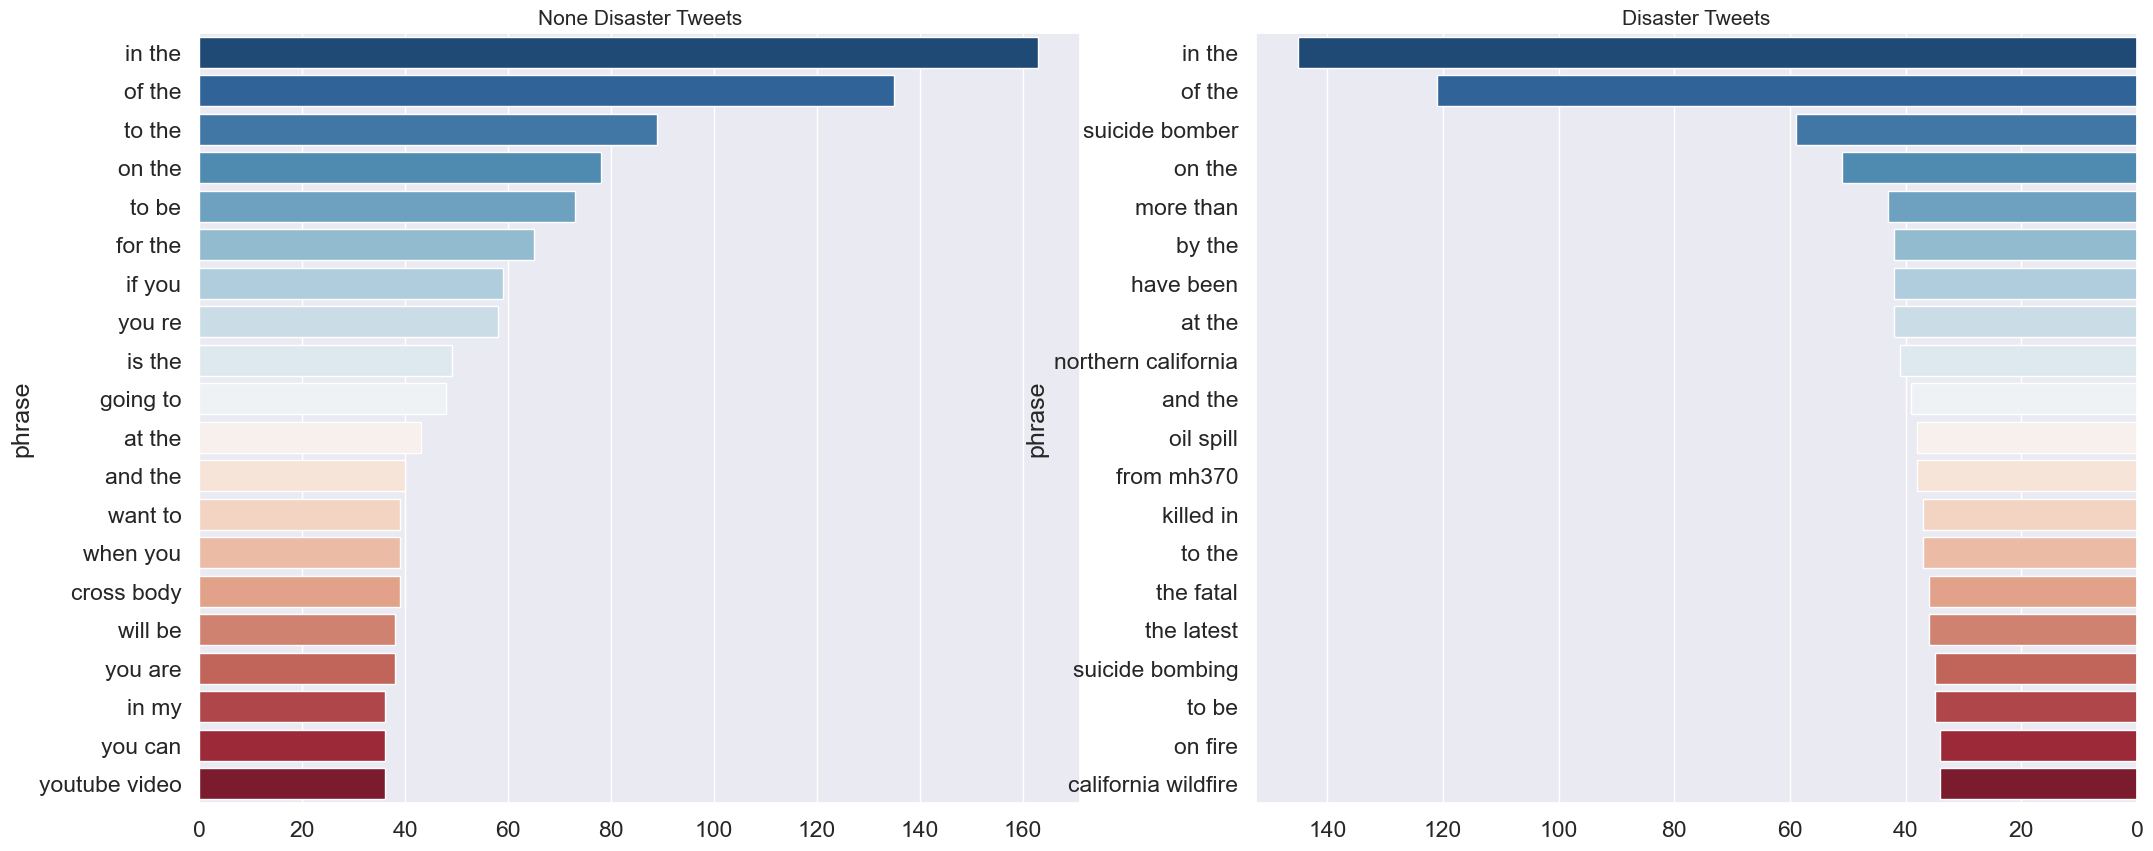

In [170]:
df_pos = get_top_n_words(corpus= train_df[train_df['Disaster'] == 1]['text'], ngram=2, n=20)
df_neg = get_top_n_words(corpus= train_df[train_df['Disaster'] == 0]['text'], ngram=2, n=20)
plot_ngram(df_pos, df_neg)

### 2.2 The distribution of top bigrams after removing stop words

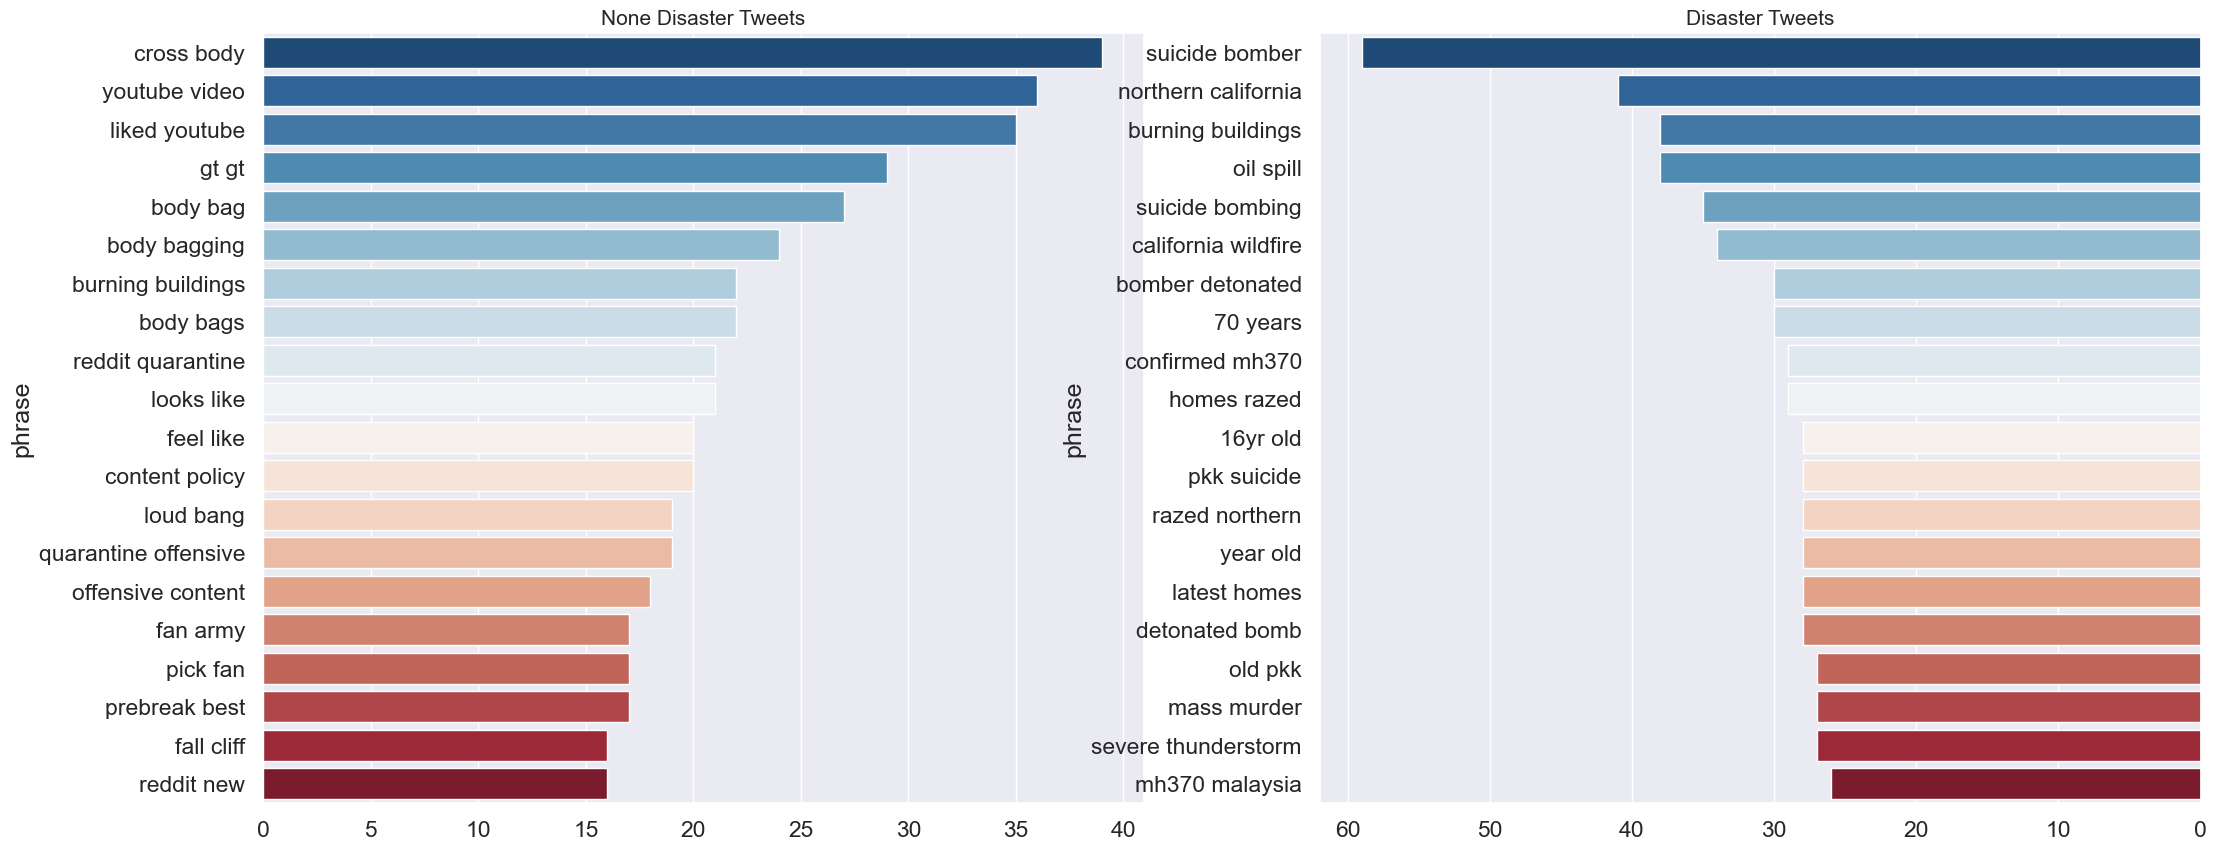

In [171]:
df_pos = get_top_n_words(corpus= train_df[train_df['Disaster'] == 1]['text'], ngram=2, stop_words= 'english', n=20)
df_neg = get_top_n_words(corpus= train_df[train_df['Disaster'] == 0]['text'], ngram=2, stop_words= 'english', n=20)
plot_ngram(df_pos, df_neg)

### 3.1 The distribution of Top trigrams before removing stop words

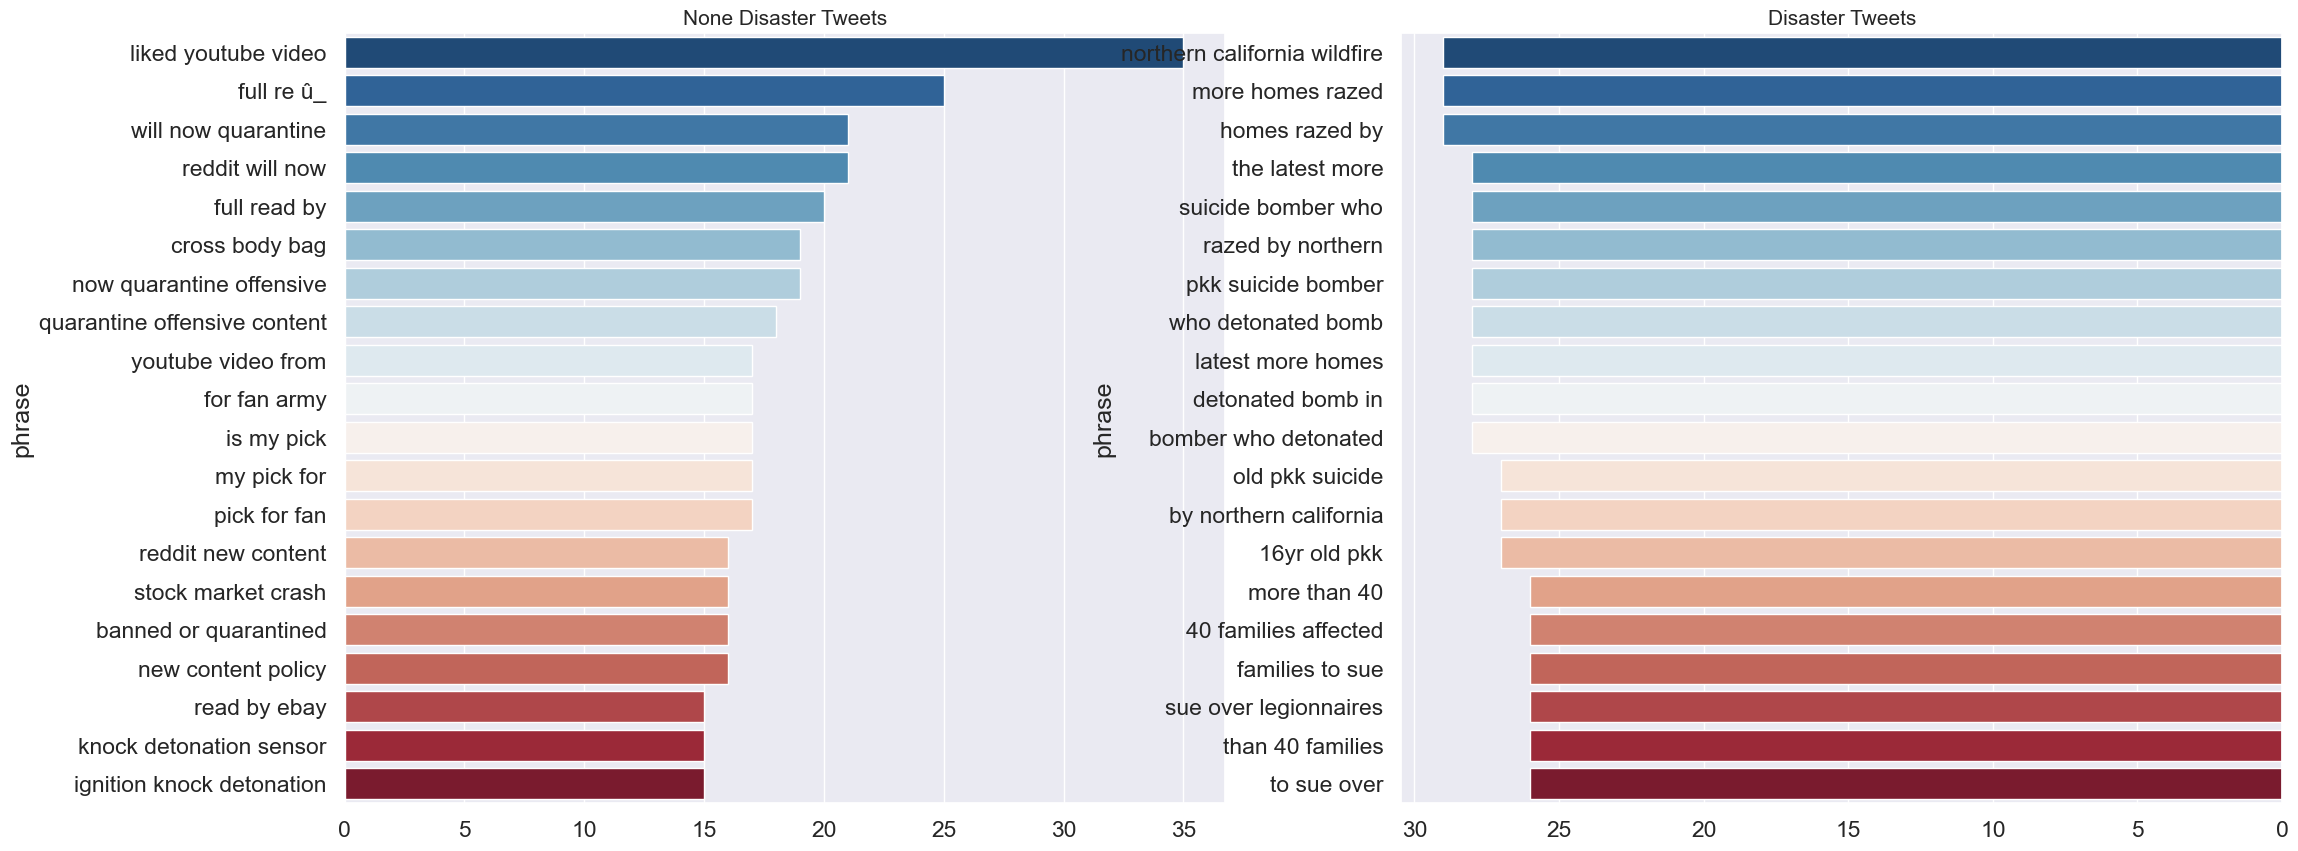

In [172]:
df_pos = get_top_n_words(corpus= train_df[train_df['Disaster'] == 1]['text'], ngram=3, n=20)
df_neg = get_top_n_words(corpus= train_df[train_df['Disaster'] == 0]['text'], ngram=3, n=20)
plot_ngram(df_pos, df_neg)

### 3.2 The distribution of Top trigrams after removing stop words

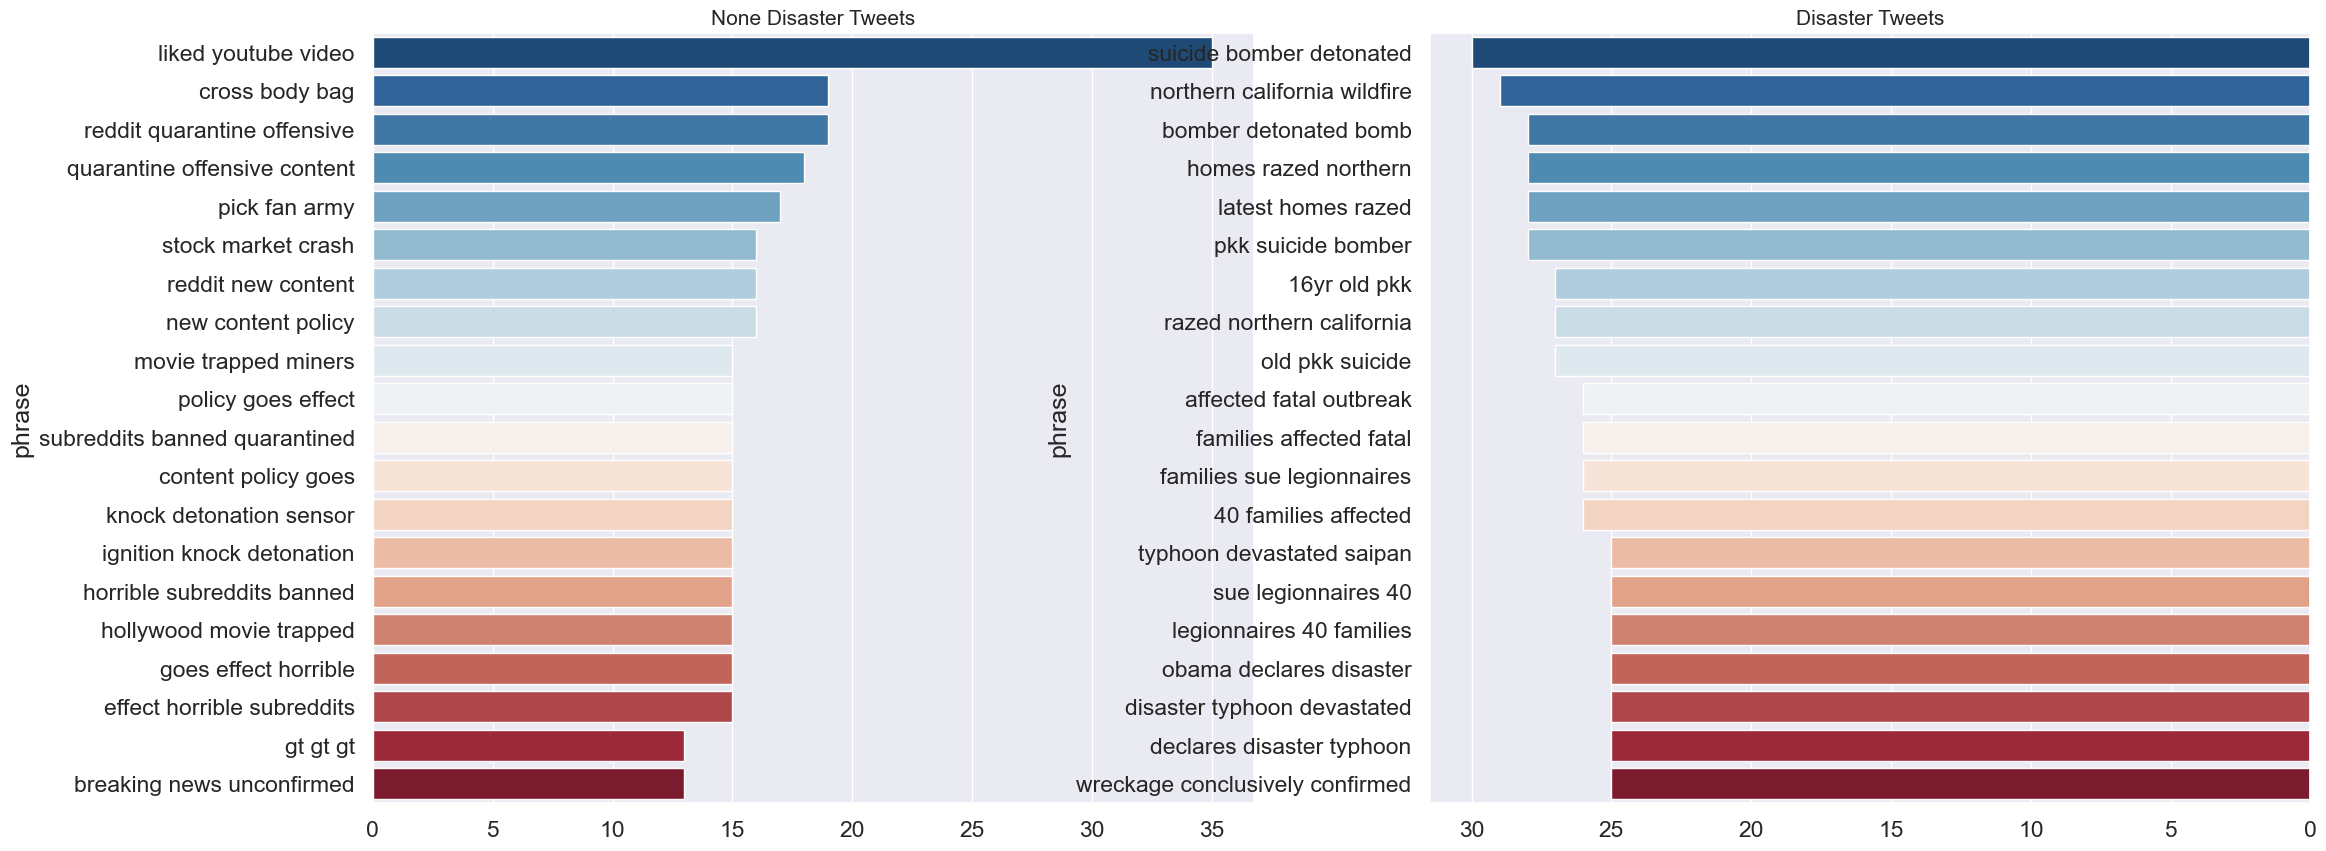

In [173]:
df_pos = get_top_n_words(corpus= train_df[train_df['Disaster'] == 1]['text'], ngram=3, stop_words= 'english', n=20)
df_neg = get_top_n_words(corpus= train_df[train_df['Disaster'] == 0]['text'], ngram=3, stop_words= 'english', n=20)
plot_ngram(df_pos, df_neg)

## Insights:
- The data needs to be cleaned from URLs and stop words should be removed to have a meaningful distribution of common phrases in both classes .
- There is a clear difference of N-Gram output for each class.


## **Exploring Linguistic Features**


## Part of Speech Analysis using Spacy

In [174]:
import spacy

In [175]:
nlp = spacy.load('en_core_web_lg')

In [176]:
import itertools
def pos(text, model=nlp):
    # Create doc object
    doc = model(text)
    # Generate list of POS tags
    pos = [token.pos_ for token in doc]
  
    # Return number of other nouns
    return (pos.count('NOUN'), pos.count('PROPN'), pos.count('AUX'), pos.count('VERB'))


In [177]:
train_df.loc[:, ('noun_count', 'pnoun_count','aux_count', 'verb_count')] = np.array(train_df['text'].apply(pos).tolist())

In [178]:
train_df.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'Disaster',
       'text_lenght', 'wordcount', 'max_word_lenght', 'avg_word_lenght',
       'noun_count', 'pnoun_count', 'aux_count', 'verb_count'],
      dtype='object')

In [179]:
def hit_plot(feature):
    avg_1 = train_df[train_df['Disaster'] == 1][feature].mean()
    avg_0 = train_df[train_df['Disaster'] == 0][feature].mean()
    print(f'\nAverage {feature} for disaster tweet is {avg_1}\nAverage {feature} for none disaster tweet is {avg_0}')
    plot = sns.displot(train_df, x=feature, col="Disaster",hue="Disaster", palette='RdBu_r', kde=True, height=8, aspect=1)
    plot.fig.suptitle(f"{feature} in a Tweet")
    plt.show()



Average noun_count for disaster tweet is 3.792892156862745
Average noun_count for none disaster tweet is 3.191998160496666


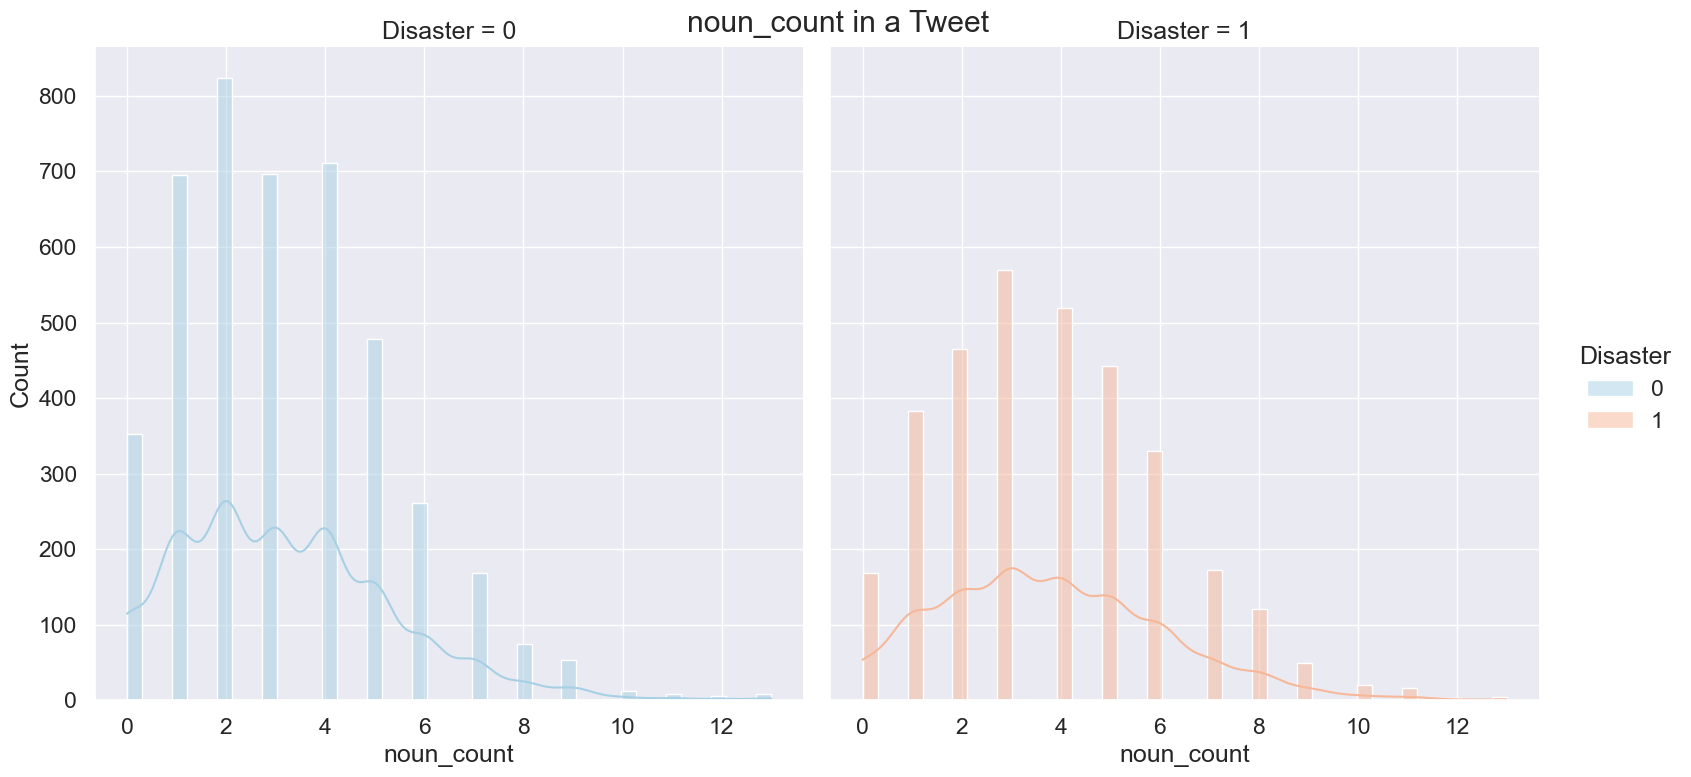


Average pnoun_count for disaster tweet is 2.9607843137254903
Average pnoun_count for none disaster tweet is 2.300988733042079


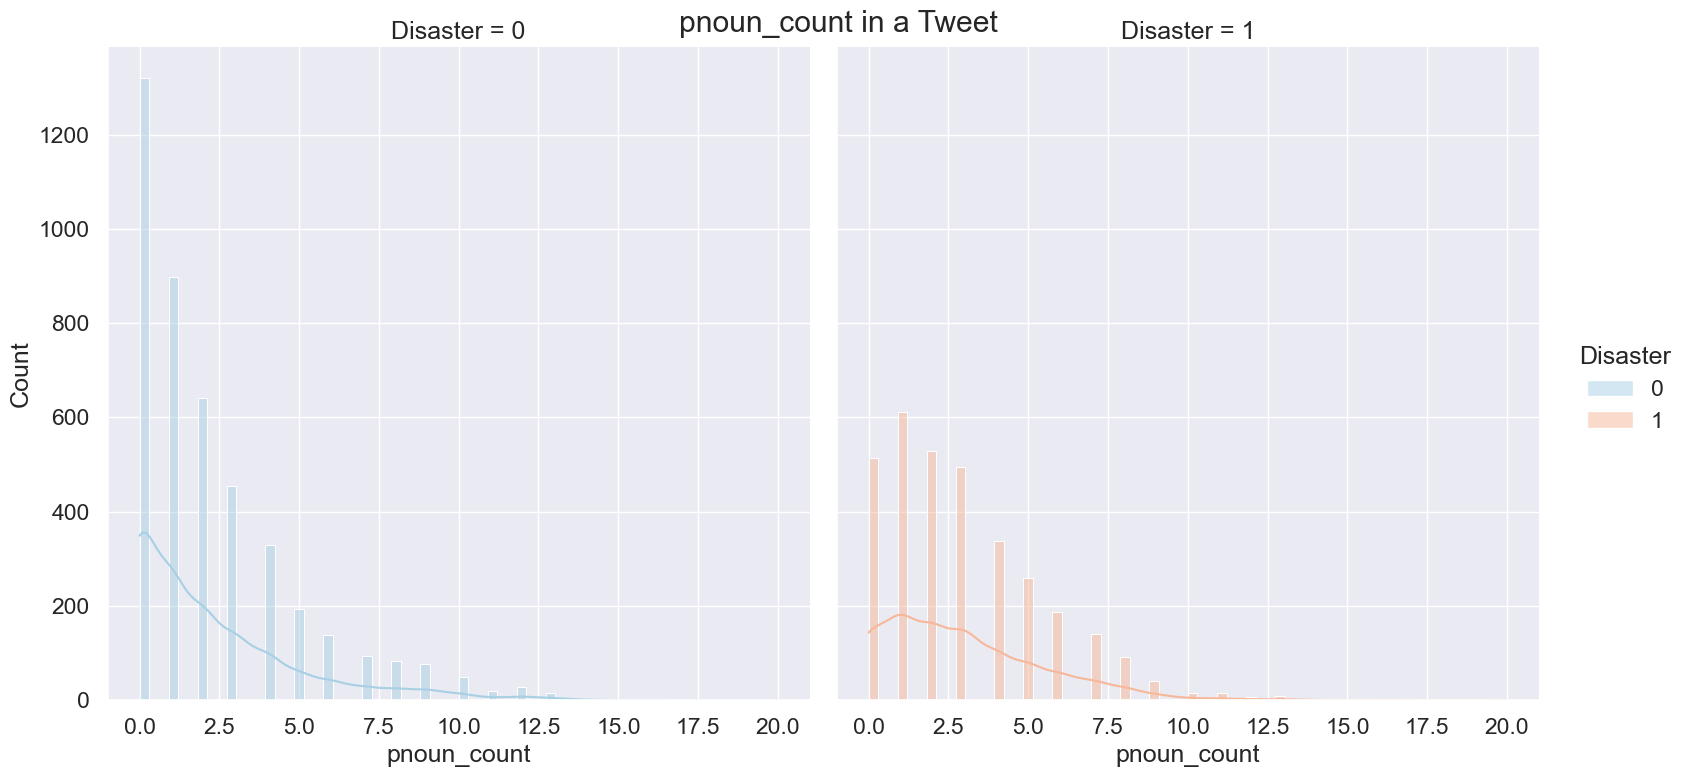


Average aux_count for disaster tweet is 0.5186887254901961
Average aux_count for none disaster tweet is 0.7052195907105082


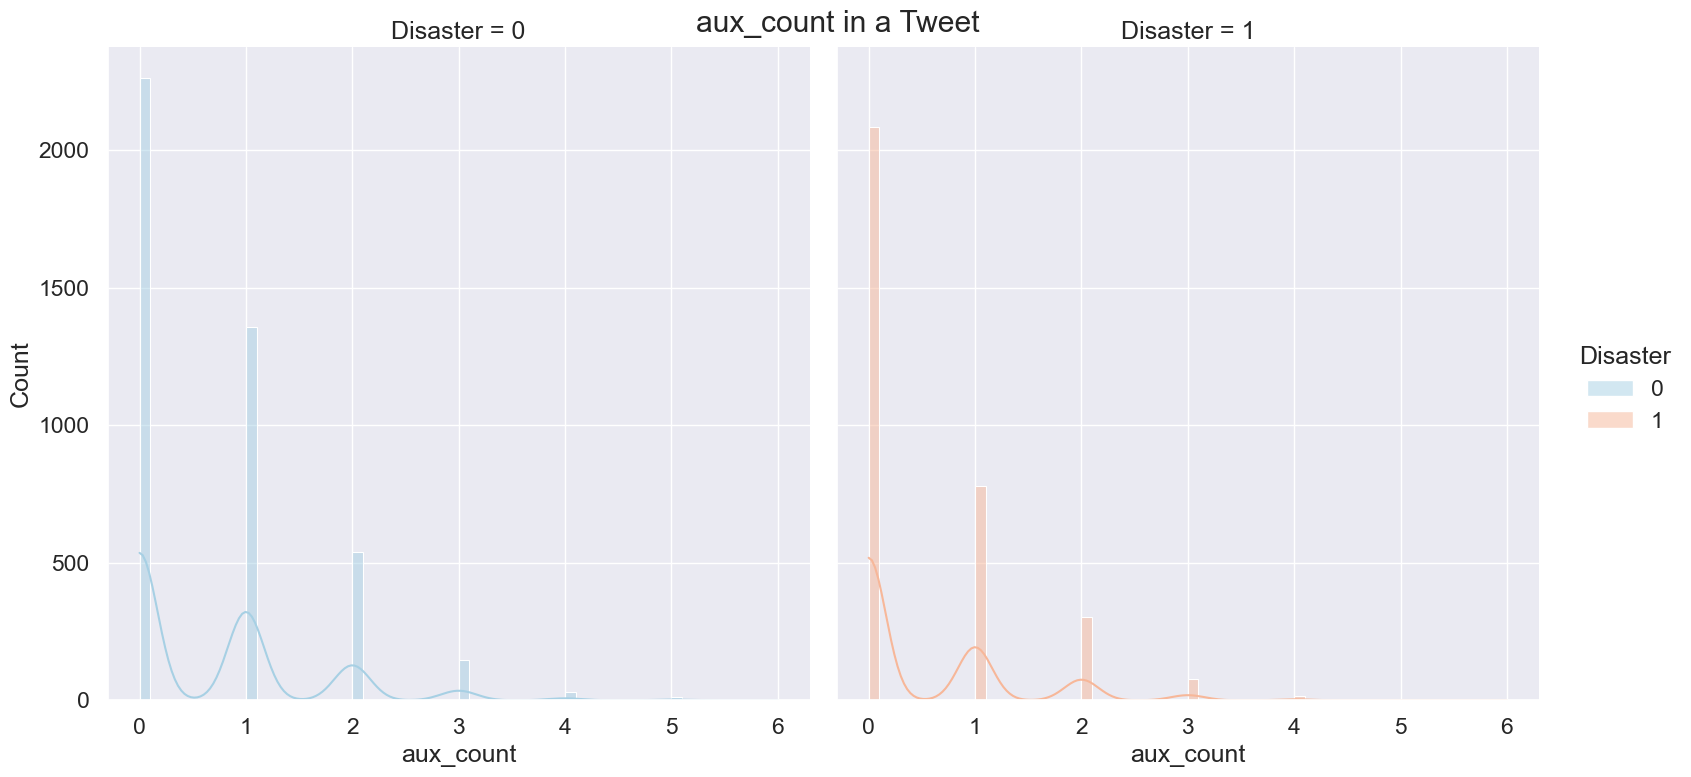


Average verb_count for disaster tweet is 1.8385416666666667
Average verb_count for none disaster tweet is 2.0531156587721315


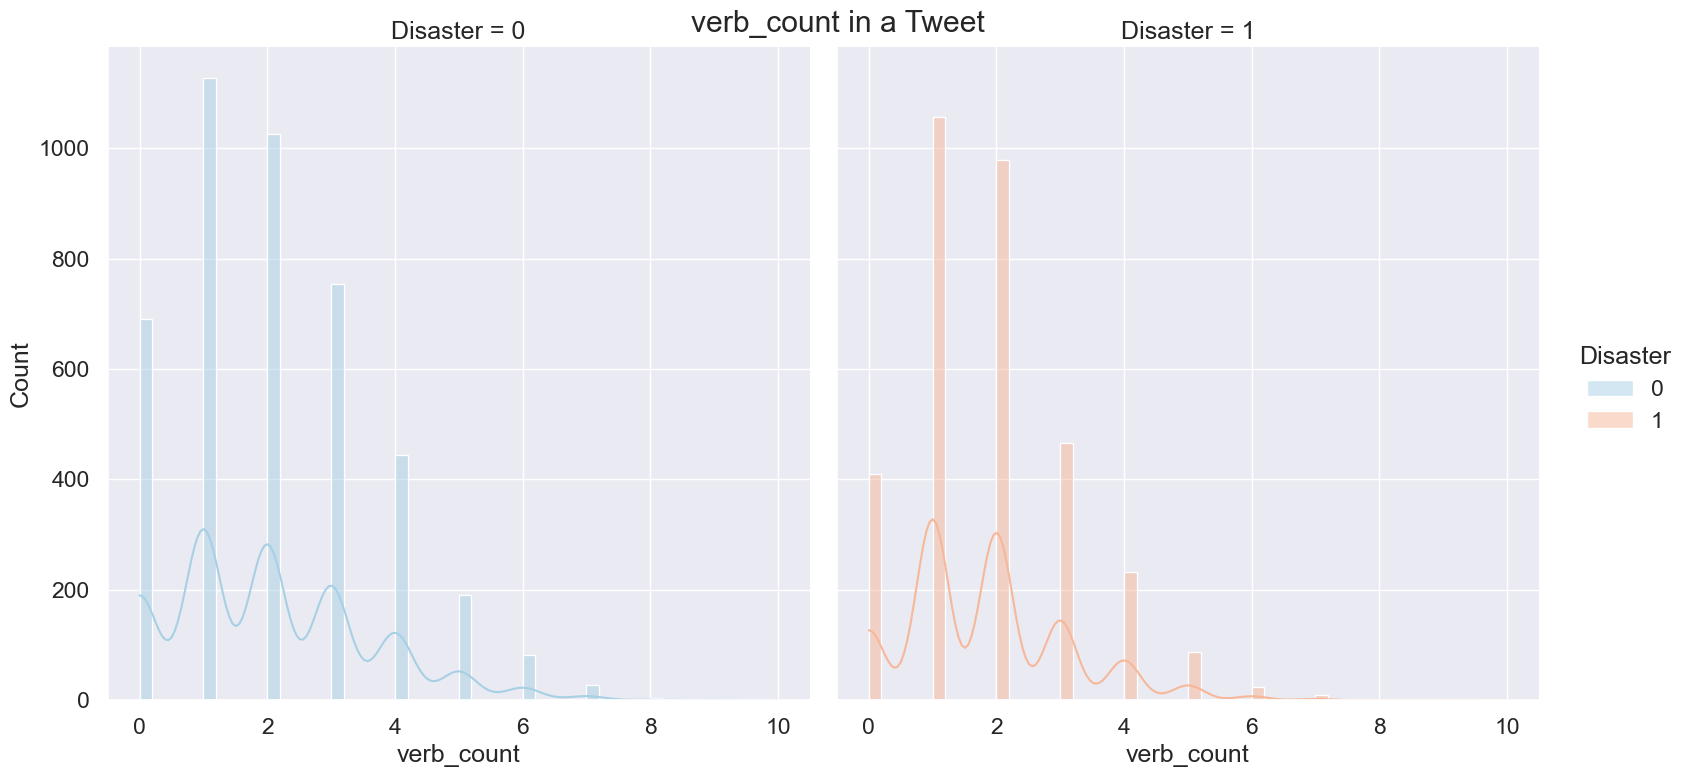

In [180]:

pos_features = ['noun_count', 'pnoun_count','aux_count', 'verb_count']
for feature in pos_features:
    hit_plot(feature)

## Insights:
- The Linguistic Features, except the proper nouns, seems to have similar distribution for both classes.
- The predictive power of these features will be examined next.


## Predictive Power Analysis

### Predictive Power Score (PPS)

In [181]:
import ppscore as pps

In [182]:
def heatmap(df):
    """This function generates the heatmap for the calculated predictive power score (PPS) matrix"""
    df = df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
    fig, ax = plt.subplots(figsize=(20, 18))
    ax = sns.heatmap(df, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, annot_kws={"fontsize":13})
    ax.set_title("Predictive Power Score (PPS) matrix")
    ax.set_xlabel("feature")
    ax.set_ylabel("target")
    plt.show()

In [183]:
train_subset = train_df.drop(['id', 'keyword', 'location', 'text', 'target'], axis=1)

In [184]:
df = pps.matrix(train_subset)

In [185]:
df['ppscore'] = round(df['ppscore'], 2)


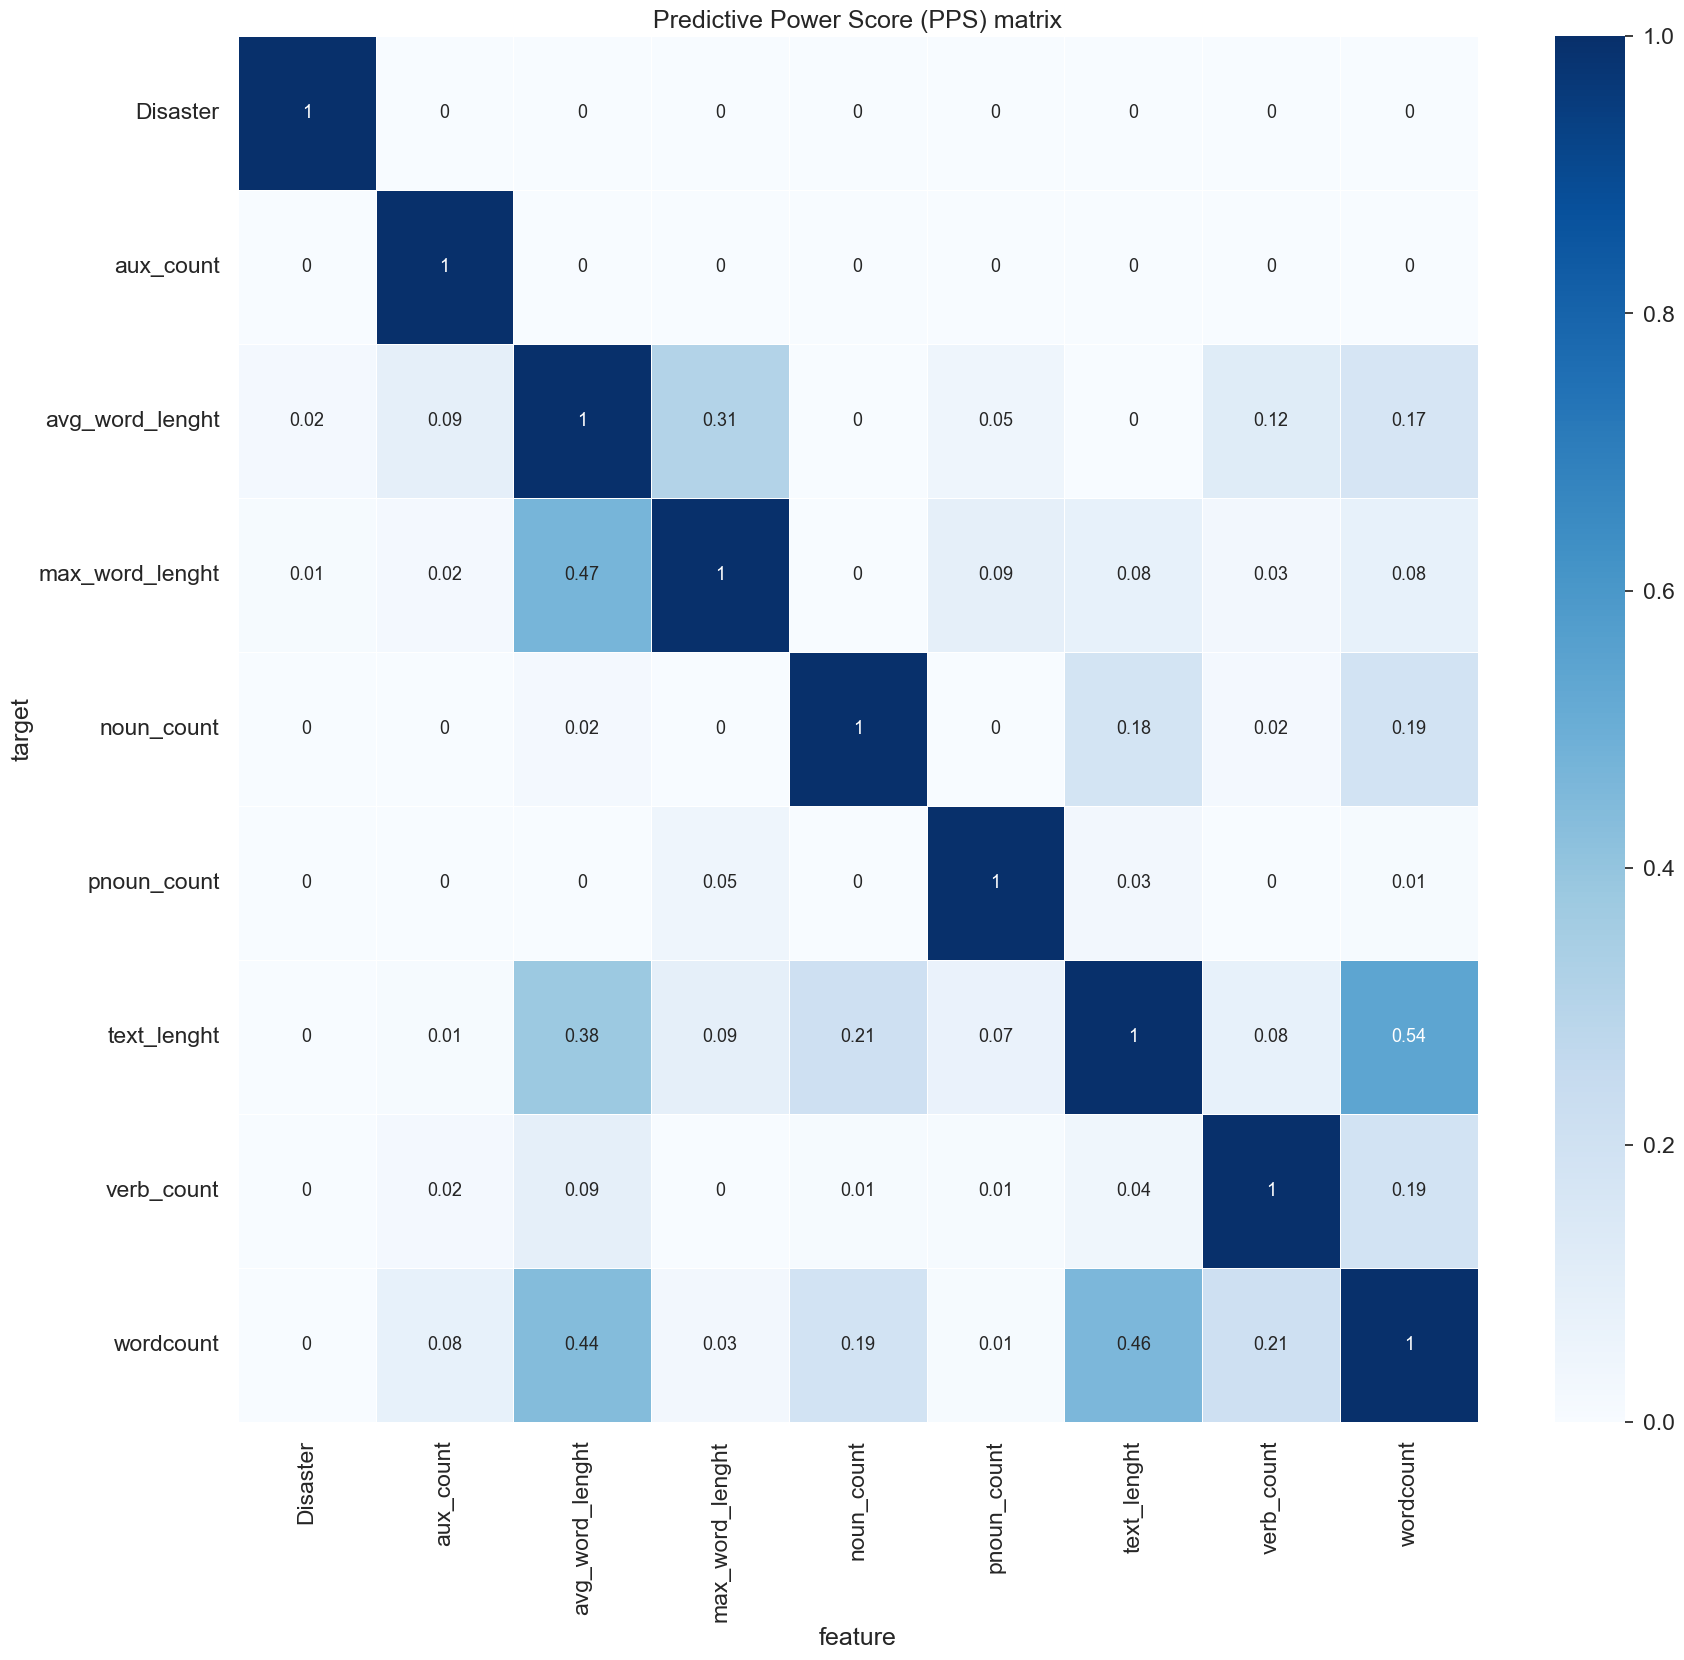

In [186]:
heatmap(df)

### Correlation Analysis

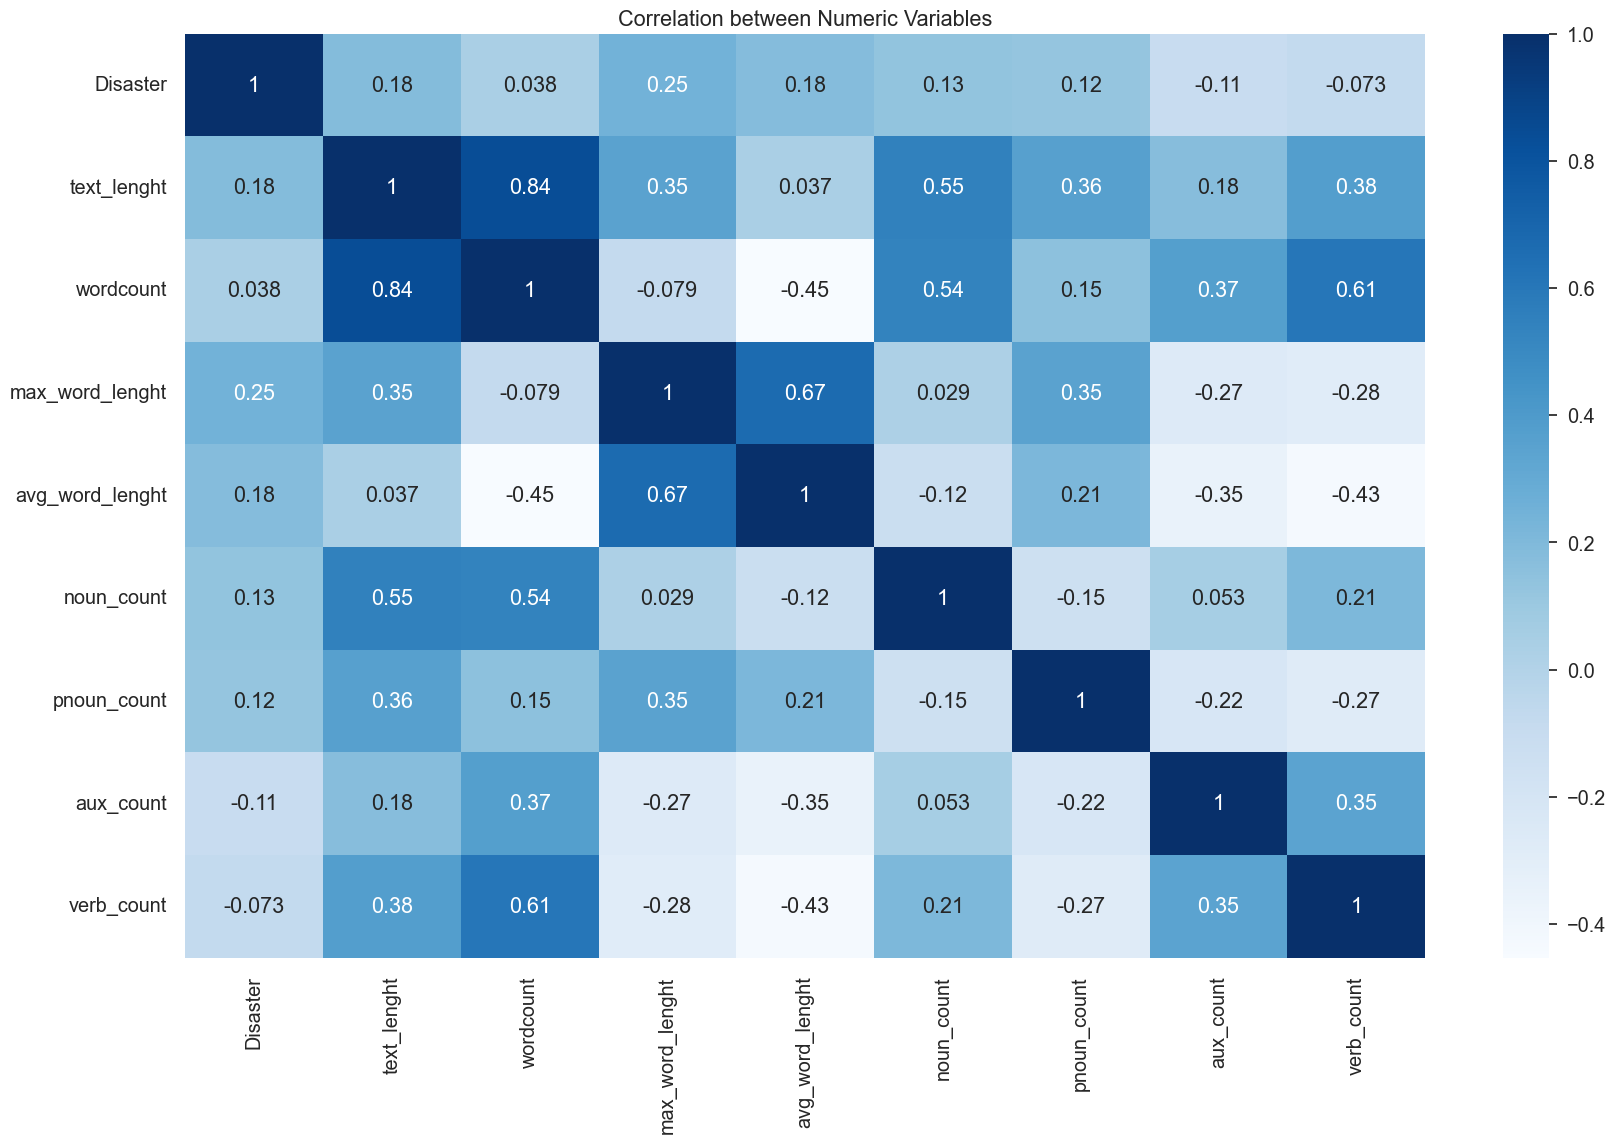

In [187]:
sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20, 12))
ax = sns.heatmap(train_subset.corr(), annot=True, ax=ax, cmap="Blues"); ax.set_title("Correlation between Numeric Variables")
plt.show()

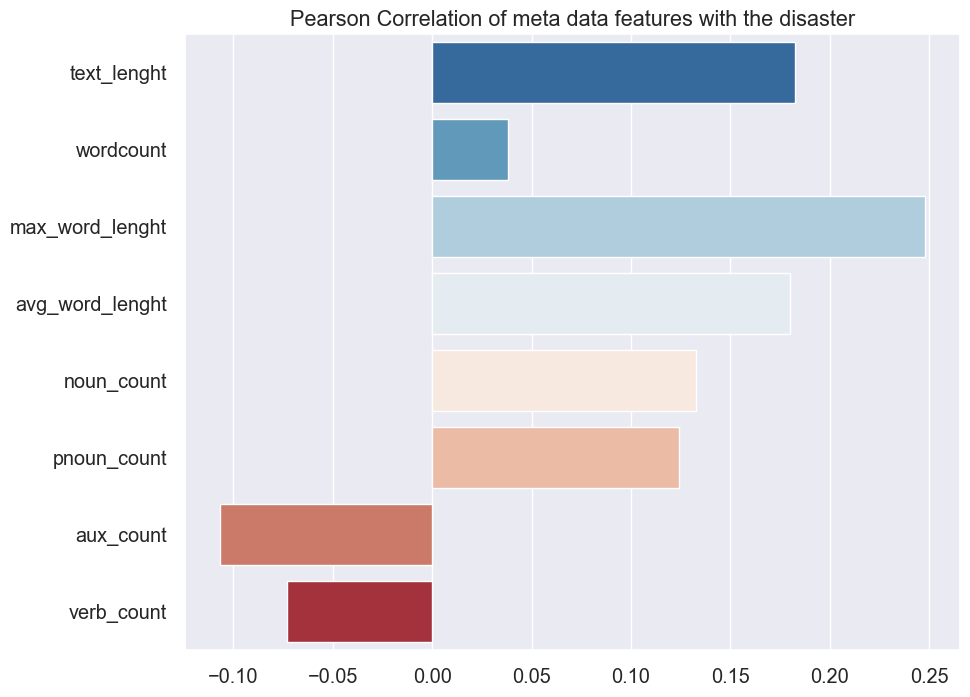

In [188]:
corr = train_subset.corr()['Disaster'].drop('Disaster')
fig, ax = plt.subplots(figsize=(10, 8))
plot = sns.barplot(y = corr.index, x = corr.values, palette='RdBu_r');
ax.set_title('Pearson Correlation of meta data features with the disaster')
plt.show()


## Insights:
- As we noticed from the distribution analysis of the meta data features, the PPS confirms that the computed meta features have no predictive power to the target variable (PPS = 0 for all variables), "disaster" in this case.
- Pearson correlation showed some weak correlation of these meta data variables with the maximum word length being the highest (r = 0.25). However, Pearson correlation can give misleading results for a binary classification problem (i.e. examining binary target variable), at least, it is not good option. [Chick this for more details.](https://stats.stackexchange.com/questions/119835/correlation-between-a-nominal-iv-and-a-continuous-dv-variable)
- Based on PPS values, these variables should not be used in modeling.


### Emoji Analysis

In [189]:
from advertools import extract_emoji

#### External example shows the use of extract_emoji of advertools package 

In [190]:
s =  ['These 👧 Emojis, 😈 are 🤖 embedded 😺 within 😻 this 🙀 text.', 'Another 😀 Emoji 💛 list']

In [191]:
extract_emoji(s)

{'emoji': [['👧', '😈', '🤖', '😺', '😻', '🙀'], ['😀', '💛']],
 'emoji_text': [['girl',
   'smiling face with horns',
   'robot',
   'grinning cat',
   'smiling cat with heart-eyes',
   'weary cat'],
  ['grinning face', 'yellow heart']],
 'emoji_flat': ['👧', '😈', '🤖', '😺', '😻', '🙀', '😀', '💛'],
 'emoji_flat_text': ['girl',
  'smiling face with horns',
  'robot',
  'grinning cat',
  'smiling cat with heart-eyes',
  'weary cat',
  'grinning face',
  'yellow heart'],
 'emoji_counts': [6, 2],
 'emoji_freq': [(2, 1), (6, 1)],
 'top_emoji': [('👧', 1),
  ('😈', 1),
  ('🤖', 1),
  ('😺', 1),
  ('😻', 1),
  ('🙀', 1),
  ('😀', 1),
  ('💛', 1)],
 'top_emoji_text': [('girl', 1),
  ('smiling face with horns', 1),
  ('robot', 1),
  ('grinning cat', 1),
  ('smiling cat with heart-eyes', 1),
  ('weary cat', 1),
  ('grinning face', 1),
  ('yellow heart', 1)],
 'top_emoji_groups': [('Smileys & Emotion', 7), ('People & Body', 1)],
 'top_emoji_sub_groups': [('cat-face', 3),
  ('person', 1),
  ('face-negative', 1),
  ('

#### Numer of emojis in a tweet

In [192]:
def emoji_count(message):
    dict_emoji = extract_emoji(message)
    return dict_emoji['overview']['num_emoji']

In [193]:
# create emoji_count column
train_df['emoji_count'] = train_df['text'].apply(emoji_count)

In [194]:
train_df['emoji_count'].value_counts()

0    7603
1      10
Name: emoji_count, dtype: int64

In [195]:
#filter tweets contains emojis in separate dataframe
mask = train_df['emoji_count'] != 0
imoji_df = train_df[mask]

In [196]:
imoji_df

id    keyword                        location  \
2171   3114     debris              46.950109,7.439469   
2172   3115     debris                             NaN   
2173   3116     debris                             NaN   
2179   3123     debris                         Seattle   
3479   4974  explosion                             NaN   
4390   6241  hijacking              South Pasadena, CA   
7127  10209    volcano   ? ??????? ? ( ?? å¡ ? ? ? å¡)   
7514  10747   wreckage                             NaN   
7527  10765   wreckage                          iTunes   
7532  10770   wreckage                          iTunes   

                                                                                                                      text  \
2171                                       How Missing JetÛªs Debris Could Have Floated to RÌ©union - The New York Times    
2172                                      RÌ©union Debris Is Almost Surely From Flight 370 Officials Say - New York Times    
2173                                      RÌ©union Debris Is Almost Surely From Flight 370 Officials Say - New York Times    
2179  #love #food #fun Malaysian Prime Minister Najib Razak confirmed that the aircraft debris found on RÌ©union Isla...     
3479                                              Exploring New Worlds: Three Moments of an Explosion by China MiÌ©ville     
4390         @ladyfleur The example I used is even worse in that it's a cafÌ© trying to market itself w/hashtag hijacking.   
7127           nside a Dragon's belly. Or an ice cave under\na volcano in Kamchatka | Photography by\nå©Daniel Korzhonov\n   
7514   #science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...     
7527   #science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...     
7532   #science Now that a piece of wreckage from flight MH370 has been confirmed on RÌ©union Island is it possible t...     

      target  Disaster  text_lenght  wordcount  max_word_lenght  \
2171       1         1          101         15               22   
2172       1         1          102         15               22   
2173       1         1          102         15               22   
2179       1         1          138         18               22   
3479       1         1          116         13               22   
4390       0         0          109         19               10   
7127       1         1          126         19               22   
7514       1         1          137         21               22   
7527       1         1          137         21               22   
7532       1         1          137         21               22   

      avg_word_lenght  noun_count  pnoun_count  aux_count  verb_count  \
2171         5.800000           2            6          2           2   
2172         5.866667           3            6          1           1   
2173         5.866667           3            6          1           1   
2179         6.666667           6            7          0           3   
3479         8.000000           3            5          0           1   
4390         4.789474           6            0          1           4   
7127         5.684211           4            8          0           1   
7514         5.523810           6            5          3           1   
7527         5.523810           6            5          3           1   
7532         5.523810           6            5          3           1   

      emoji_count  
2171            1  
2172            1  
2173            1  
2179            1  
3479            1  
4390            1  
7127            1  
7514            1  
7527            1  
7532            1

In [197]:
def top_emoji(message):
    dict_emoji = extract_emoji(message)
    return dict_emoji['top_emoji'][0], dict_emoji['emoji_flat_text']

In [198]:
dict_emoji = imoji_df['text'].apply(top_emoji)

In [199]:
dict_emoji

2171    ((©, 1), [copyright])
2172    ((©, 1), [copyright])
2173    ((©, 1), [copyright])
2179    ((©, 1), [copyright])
3479    ((©, 1), [copyright])
4390    ((©, 1), [copyright])
7127    ((©, 1), [copyright])
7514    ((©, 1), [copyright])
7527    ((©, 1), [copyright])
7532    ((©, 1), [copyright])
Name: text, dtype: object

## Insights:
- There are only 10 copyright ( © ) emojis in 10 tweets. 9 of these tweets are disaster tweets.
- However, we can not use emojis for modeling because there are only 10 in the training data set.


## Saving the Data

Saving data in the /data/interim, based on the kind of modeling other data cleaning and transformation steps can be applied. Now the data in its interim state.   

### Train data

In [200]:
datapath = '../data/interim/'

#### 1. Train and meta data

In [201]:
datapath_train_meta = os.path.join(datapath, 'interim_train_meta_df.csv')
if not os.path.exists(datapath_train_meta):
    train_df.to_csv(datapath_train_meta, index=False)

#### 2. Train Modeling data

In [202]:
interim_train_df = train_df.loc[:, ['text', 'Disaster']]

In [203]:
datapath_train = os.path.join(datapath, 'interim_train_df.csv')
if not os.path.exists(datapath_train):
    interim_train_df.to_csv(datapath_train, index=False)

### Test data

In [204]:
interim_test_df = test_df.copy()

In [205]:
datapath_test = os.path.join(datapath, 'interim_test_df.csv')
if not os.path.exists(datapath_test):
    interim_test_df.to_csv(datapath_test, index=False)

In [206]:
interim_test_df

id keyword location  \
0         0     NaN      NaN   
1         2     NaN      NaN   
2         3     NaN      NaN   
3         9     NaN      NaN   
4        11     NaN      NaN   
...     ...     ...      ...   
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                                                                                                             text  
0                                                                                                              Just happened a terrible car crash  
1                                                                                Heard about #earthquake is different cities, stay safe everyone.  
2                                                there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all  
3                                                                                                        Apocalypse lighting. #Spokane #wildfires  
4                                                                                                   Typhoon Soudelor kills 28 in China and Taiwan  
...                                                                                                                                           ...  
3258                                                                                      EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTENERS XrWn  
3259  Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power  
3260                                                                                                            Green Line derailment in Chicago   
3261                                                                                                  MEG issues Hazardous Weather Outlook (HWO)   
3262                                                                         #CityofCalgary has activated its Municipal Emergency Plan. #yycstorm  

[3263 rows x 4 columns]